In [554]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import ternary
import seaborn as sns
import statsmodels.api as sm
from scipy import interp
from itertools import cycle
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import logistic
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
import pydotplus
from IPython.display import Image 
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [555]:
df_2018 = pd.read_csv('data_prep/indicators_2018_key.csv')
df_2017 = pd.read_csv('data_prep/indicators_pr_2017.csv')
df_2016 = pd.read_csv('data_prep/indicators_pr_2016.csv')
df = pd.concat([df_2018, df_2017, df_2016], ignore_index=True)

### Кодируем зависимую переменную

In [556]:
df.status = df.status.fillna('0')
df['all_pr'] = df.status.apply(lambda x: 1 if x != '0' else 0)
df['det_pr'] = df.status.apply(lambda x: 1 if ('1' in x or '4' in x) else 
                               (2 if ('2' in x or '3' in x or '5' in x) else 0))

In [557]:
df.all_pr.describe()

count    1340.000000
mean        0.061194
std         0.239775
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: all_pr, dtype: float64

In [558]:
df.det_pr.describe()

count    1340.000000
mean        0.091045
std         0.377576
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: det_pr, dtype: float64

In [559]:
df.det_pr[df.det_pr != 0].count()

82

### Разбираемся с нечисловыми столбцами

In [560]:
df.select_dtypes(include='object').head()

,2.1000000000000001,2.1099999999999999,2.1499999999999999,2.1600000000000001,2.2000000000000002,2.2999999999999998,2.3999999999999999,2.5,2.6000000000000001,address,comment,comment_date,name,response,status,t1_3,t1_4,t1_5,t1_6,t1_7,t2_1_E.6,t2_2_E.5,t2_3_E.1,t2_3_E.2,t2_3_E.3,t2_3_E.4,t2_3_E.5,t2_3_E.6,t2_3_E.7,t2_3_E.8,t5_54
0,27.940000000000001,6,5,7.1299999999999999,15.16,584.41999999999996,3.5699999999999998,2.3799999999999999,383.47000000000003,"656031, Алтайский край, г. Барнаул, ул.Молодеж...",NaN,NaN,Федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Черниченко Борис Алексеевич,Министерство образования и науки Российской Фе...,http://uni-altai.ru,Министерство образования и науки РФ,"образовательные организации, не имеющие специф...",70,показатель,0.5,1.3,10.5,2,0.40000000000000002,NaN,NaN,–5.5,да
1,60.18,1,8,4.2300000000000004,86.799999999999997,1123.3900000000001,11.34,15.73,294.42000000000002,"658038, Алтайский край, г.Барнаул, пр.Ленина, 46",NaN,NaN,федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Марков Андрей Михайлович,Министерство образования и науки Российской Фе...,http://www.altstu.ru,Министерство образования и науки Российской Фе...,"образовательные организации, не имеющие специф...",75,показатель,1,–23.9,17.399999999999999,–3.4,12.199999999999999,NaN,NaN,15.6,да
2,189.34,2,39,10.609999999999999,210.22999999999999,2039.1700000000001,45.869999999999997,39.659999999999997,395.32999999999998,"656049, Алтайский край, г.Барнаул, пр. Ленина,61",NaN,NaN,федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Землюков Сергей Валентинович,Министерство образования и науки Российской Фе...,http://www.asu.ru/,Министерство образования и науки Российской Фе...,"образовательные организации, не имеющие специф...",65,показатель,–1.1,6.5999999999999996,17.199999999999999,7.5,–1.0,NaN,NaN,–17.4,да
3,26.760000000000002,0,5,7.7699999999999996,46.909999999999997,156.83000000000001,8.6300000000000008,10.359999999999999,333.81,"675027, Амурская область, г. Благовещенск, Игн...",NaN,NaN,федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Плутенко Андрей Долиевич,Министерство образования и науки Российской Фе...,http://www.amursu.ru,Министерство образования и науки Российской фе...,"образовательные организации, не имеющие специф...",65,показатель,0.5,5.5,1,4.5,5.2000000000000002,NaN,NaN,0.40000000000000002,да
4,8.1899999999999995,0,1,2.23,8.9399999999999995,324.01999999999998,3.7200000000000002,2.98,227.93000000000001,"681000, Хабаровский край, г. Комсомольск-на-Ам...",NaN,NaN,федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Бавыкин Виктор Станиславович,Министерство образования и науки Российской Фе...,http://www.amgpgu.ru,Министерство образования и науки Российской Фе...,"образовательные организации, не имеющие специф...",65,показатель,–1.4,–11.1,–14.8,19.800000000000001,9.4000000000000004,NaN,NaN,–2.8,да


In [561]:
def replace_dash(series, symbol, val):
    new = series.replace(to_replace=symbol, value=val)
    return pd.to_numeric(new)

In [562]:
df['2.1000000000000001'] = replace_dash(df['2.1000000000000001'], '-', None)
df['2.1099999999999999'] = replace_dash(df['2.1099999999999999'], '-', None)
df['2.1499999999999999'] = replace_dash(df['2.1499999999999999'], '-', None)
df['2.1600000000000001'] = replace_dash(df['2.1600000000000001'], '-', None)
df['2.2000000000000002'] = replace_dash(df['2.2000000000000002'],'-', None)
df['2.2999999999999998'] = replace_dash(df['2.2999999999999998'], '-', None)
df['2.3999999999999999'] = replace_dash(df['2.3999999999999999'], '-', None)
df['2.5'] = replace_dash(df['2.5'], '-', None)
df['2.6000000000000001'] = replace_dash(df['2.6000000000000001'], '-', None)

In [563]:
df['t2_1_E.6'] = replace_dash(df['t2_1_E.6'], '—', -1)
df['t2_3_E.1'].fillna('-', inplace=True)
df['t2_3_E.2'].fillna('-', inplace=True)
df['t2_3_E.3'].fillna('-', inplace=True)
df['t2_3_E.4'].fillna('-', inplace=True)
df['t2_3_E.5'].fillna('-', inplace=True)
df['t2_3_E.6'].fillna('-', inplace=True)
df['t2_3_E.7'].fillna('-', inplace=True)
df['t2_3_E.8'].fillna('-', inplace=True)

In [564]:
df['t2_3_E.1'] = df['t2_3_E.1'].apply(lambda x: x.replace('–', '-'))
df['t2_3_E.2'] = df['t2_3_E.2'].apply(lambda x: x.replace('–', '-'))
df['t2_3_E.3'] = df['t2_3_E.3'].apply(lambda x: x.replace('–', '-'))
df['t2_3_E.4'] = df['t2_3_E.4'].apply(lambda x: x.replace('–', '-'))
df['t2_3_E.5'] = df['t2_3_E.5'].apply(lambda x: x.replace('–', '-'))
df['t2_3_E.6'] = df['t2_3_E.6'].apply(lambda x: x.replace('–', '-'))
df['t2_3_E.7'] = df['t2_3_E.7'].apply(lambda x: x.replace('–', '-'))
df['t2_3_E.8'] = df['t2_3_E.8'].apply(lambda x: x.replace('–', '-'))

In [565]:
df['t2_3_E.1'] = replace_dash(df['t2_3_E.1'], '-', -1)
df['t2_3_E.2'] = replace_dash(df['t2_3_E.2'], '-', -1)
df['t2_3_E.3'] = replace_dash(df['t2_3_E.3'], '-', -1)
df['t2_3_E.4'] = replace_dash(df['t2_3_E.4'], '-', -1)
df['t2_3_E.5'] = replace_dash(df['t2_3_E.5'], '-', -1)
df['t2_3_E.6'] = replace_dash(df['t2_3_E.6'], '-', -1)
df['t2_3_E.7'] = replace_dash(df['t2_3_E.7'], '-', -1)
df['t2_3_E.8'] = replace_dash(df['t2_3_E.8'], '-', -1)

In [566]:
df['t5_54'] = df['t5_54'].apply(lambda x: 1 if x == 'да' else 0)

In [567]:
df.select_dtypes(include='object').head()

,address,comment,comment_date,name,response,status,t1_3,t1_4,t1_5,t1_6,t1_7,t2_2_E.5
0,"656031, Алтайский край, г. Барнаул, ул.Молодеж...",NaN,NaN,Федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Черниченко Борис Алексеевич,Министерство образования и науки Российской Фе...,http://uni-altai.ru,Министерство образования и науки РФ,"образовательные организации, не имеющие специф...",показатель
1,"658038, Алтайский край, г.Барнаул, пр.Ленина, 46",NaN,NaN,федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Марков Андрей Михайлович,Министерство образования и науки Российской Фе...,http://www.altstu.ru,Министерство образования и науки Российской Фе...,"образовательные организации, не имеющие специф...",показатель
2,"656049, Алтайский край, г.Барнаул, пр. Ленина,61",NaN,NaN,федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Землюков Сергей Валентинович,Министерство образования и науки Российской Фе...,http://www.asu.ru/,Министерство образования и науки Российской Фе...,"образовательные организации, не имеющие специф...",показатель
3,"675027, Амурская область, г. Благовещенск, Игн...",NaN,NaN,федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Плутенко Андрей Долиевич,Министерство образования и науки Российской Фе...,http://www.amursu.ru,Министерство образования и науки Российской фе...,"образовательные организации, не имеющие специф...",показатель
4,"681000, Хабаровский край, г. Комсомольск-на-Ам...",NaN,NaN,федеральное государственное бюджетное образова...,<HtmlResponse 200 http://indicators.miccedu.ru...,0,Бавыкин Виктор Станиславович,Министерство образования и науки Российской Фе...,http://www.amgpgu.ru,Министерство образования и науки Российской Фе...,"образовательные организации, не имеющие специф...",показатель


### Смотрим на переменные

* t2_1_E.1	Образовательная деятельность, Значение показателя
* t2_1_E.2	Научно-исследовательская деятельность, Значение показателя
* t2_1_E.3	Международная деятельность, Значение показателя
* t2_1_E.4	Финансово-экономическая деятельность, Значение показателя
* t2_1_E.5	Заработная плата ППС, Значение показателя
* t2_1_E.6	Трудоустройство, Значение показателя
* t2_1_E.7	Приведенный контингент, Значение показателя 
* t2_1_E.8	Дополнительный показатель, Значение показателя

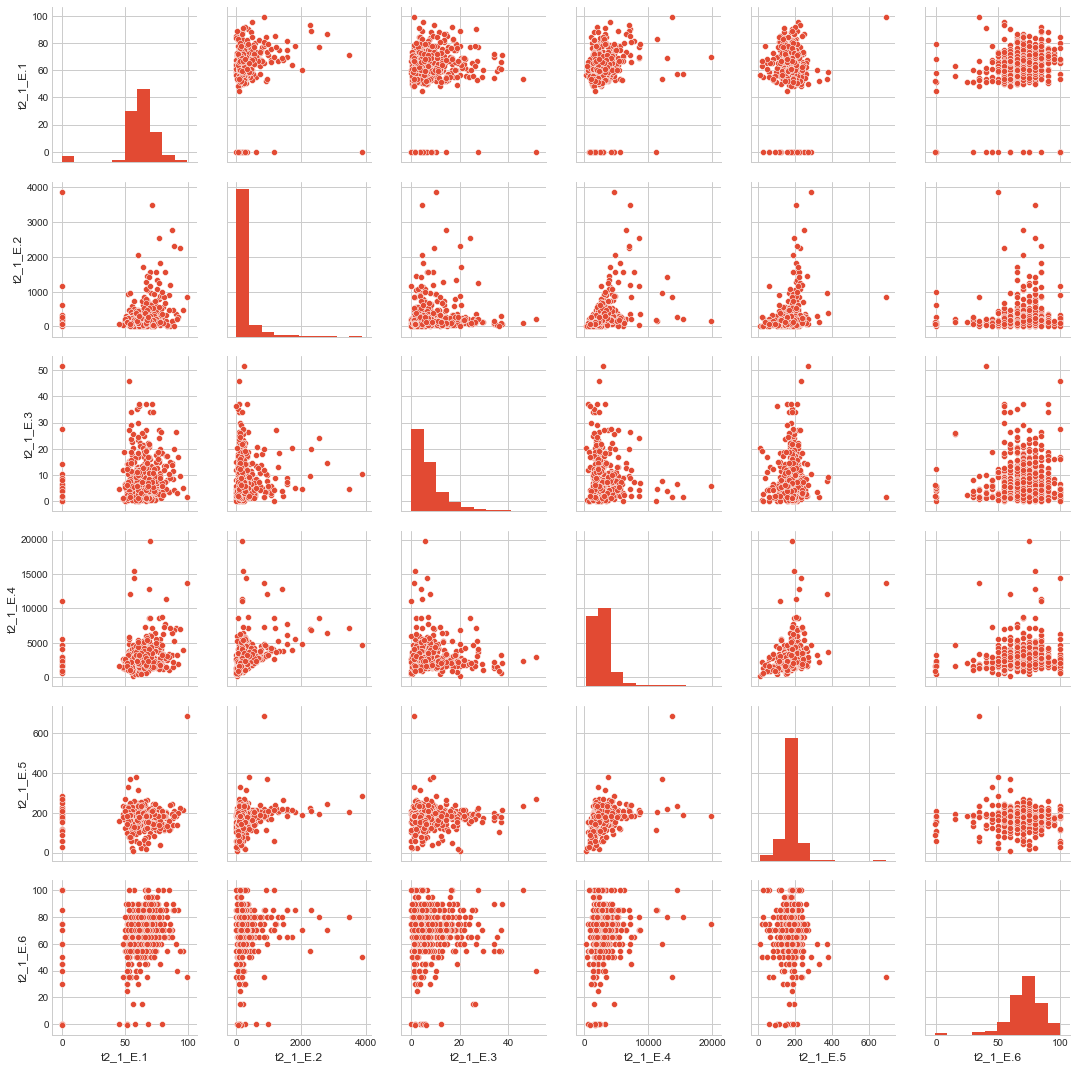

In [568]:
filter_col = [col for col in df if col.startswith('t2_1_')]
sns.pairplot(df[filter_col[:6]].dropna())

In [569]:
df[filter_col].describe()

,t2_1_E.1,t2_1_E.2,t2_1_E.3,t2_1_E.4,t2_1_E.5,t2_1_E.6,t2_1_E.7,t2_1_E.8
count,1324.000000,1324.000000,746.000000,1324.000000,1324.000000,1031.000000,578.000000,1324.000000
mean,53.452885,742.567500,7.309920,3631.672938,570.983369,68.838991,414.309862,14.804411
std,23.219811,20221.851361,7.731167,27112.039402,13198.461636,15.361889,601.814974,35.967532
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
25%,53.285000,62.442500,2.412500,1741.007500,164.480000,60.000000,84.500000,2.947500
50%,60.450000,103.740000,5.205000,2229.735000,186.385000,70.000000,238.000000,3.880000
75%,65.945000,190.825000,9.077500,3068.137500,205.055000,80.000000,463.350000,6.280000
max,99.310000,735892.540000,79.790000,981925.000000,479176.420000,100.000000,5108.800000,778.740000


Посотрим на процентное отклонение от пороговых значений

In [570]:
df['t2_E.1_diff'] = (df['t2_1_E.1'] - df['t2_2_E.1']) / df['t2_2_E.1']
df['t2_E.2_diff'] = (df['t2_1_E.2'] - df['t2_2_E.2']) / df['t2_2_E.2']
df['t2_E.3_diff'] = (df['t2_1_E.3'] - df['t2_2_E.3']) / df['t2_2_E.3']
df['t2_E.4_diff'] = (df['t2_1_E.4'] - df['t2_2_E.4']) / df['t2_2_E.4']
# unconsistent
# df['t2_E.5_diff'] = (df['t2_1_E.5'] - df['t2_2_E.5']) / df['t2_2_E.5']
df['t2_E.6_diff'] = (df['t2_1_E.6'] - df['t2_2_E.6']) / df['t2_2_E.6']
df['t2_E.7_diff'] = (df['t2_1_E.7'] - df['t2_2_E.7']) / df['t2_2_E.7']
df['t2_E.8_diff'] = (df['t2_1_E.8'] - df['t2_2_E.8']) / df['t2_2_E.8']

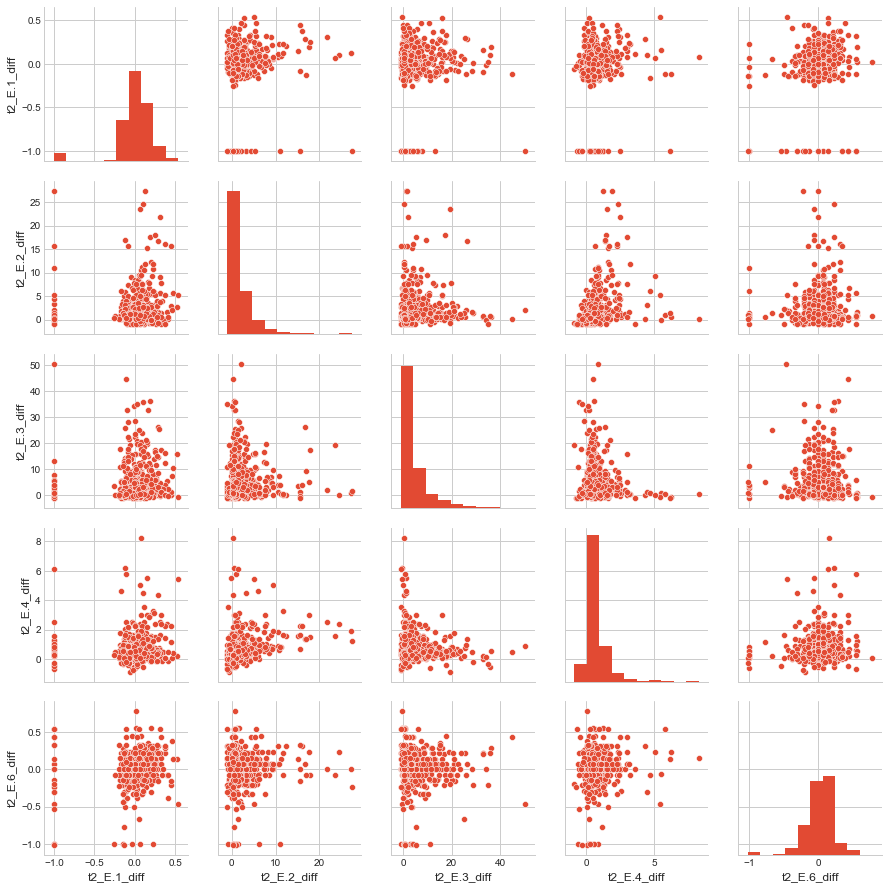

In [571]:
filter_col = [col for col in df if col.startswith('t2_E.')]
sns.pairplot(df[filter_col[:5]].dropna());

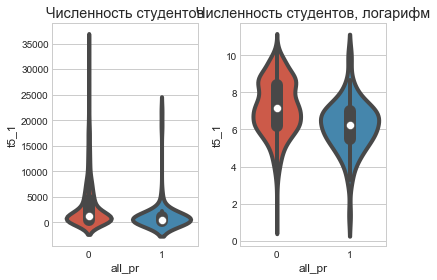

In [572]:
plt.subplot(1, 2, 1)
ax = sns.violinplot(y=df['t5_1'], x=df['all_pr'])
ax.set_title('Численность студентов')

plt.subplot(1, 2, 2)
ax = sns.violinplot(y=np.log(df['t5_1']), x=df['all_pr'])
ax.set_title('Численность студентов, логарифм')

plt.tight_layout()

* t5_1	Общая численность студентов, обучающихся по программам бакалавриата, специалитета, магистратуры, чел.
* t5_14	Общий объем средств, поступивших (за отчетный год) от выполнения НИОКР, выполненных собственными силами, тыс. руб.
* t5_16	Общее количество публикаций организации в расчете на 100 НПР, ед.
* t5_26	Общая численность работников образовательной организации (без внешних совместителей и работающих по договорам ГПХ), чел.
* t5_29	Доля ППС, имеющих ученые степени, %
* t5_33	Средняя заработная плата ППС (без внешних совместителей и работающих по договорам ГПХ), тыс. руб.
* t5_46	Общая площадь зданий (помещений), м
* t5_5	Средний балл ЕГЭ студентов, принятых на обучение по программам бакалавриата и специалитета, по всем формам обучения, балл
* t5_56	Доходы филиала  из всех источников, тыс. руб.

In [573]:
df[['t5_1', 't5_14', 't5_16', 't5_26', 't5_29', 't5_33', 't5_46', 
    't5_5', 't5_56', 'all_pr']].groupby('all_pr').describe().T

all_pr                  0             1
t5_1  count  1.244000e+03  8.000000e+01
      mean   3.361543e+03  1.308825e+03
      std    4.862789e+03  3.224843e+03
      min    3.000000e+00  4.000000e+00
      25%    4.797500e+02  2.365000e+02
      50%    1.282500e+03  5.100000e+02
      75%    4.423000e+03  1.097000e+03
      max    3.461300e+04  2.190700e+04
t5_14 count  1.244000e+03  8.000000e+01
      mean   7.176279e+04  6.654399e+03
      std    3.186628e+05  1.400122e+04
      min    0.000000e+00  0.000000e+00
      25%    1.319150e+03  9.231000e+02
      50%    5.102100e+03  2.320250e+03
      75%    3.042872e+04  6.255650e+03
      max    6.069631e+06  9.351370e+04
t5_16 count  1.244000e+03  8.000000e+01
      mean   4.667357e+02  3.585761e+02
      std    5.729178e+03  6.391694e+02
      min    0.000000e+00  0.000000e+00
      25%    0.000000e+00  8.376500e+01
      50%    2.118300e+02  1.787450e+02
      75%    4.199475e+02  4.816350e+02
      max    2.015000e+05  5.220590e+03
t5_26 count  1.244000e+03  8.000000e+01
      mean   5.020924e+02  1.083500e+02
      std    1.004833e+03  2.440116e+02
      min    0.000000e+00  5.000000e+00
      25%    4.600000e+01  3.000000e+01
      50%    1.230000e+02  5.000000e+01
      75%    5.975000e+02  9.600000e+01
      max    1.925400e+04  2.005000e+03
t5_29 count  1.244000e+03  8.000000e+01
      mean   7.399542e+01  7.648125e+01
      std    1.757856e+01  1.874352e+01
      min    0.000000e+00  0.000000e+00
      25%    6.752500e+01  6.667000e+01
      50%    7.651000e+01  8.000000e+01
      75%    8.462000e+01  8.832250e+01
      max    1.000000e+02  1.000000e+02
t5_33 count  1.244000e+03  8.000000e+01
      mean   8.430944e+01  1.936002e+03
      std    8.144524e+02  1.679693e+04
      min    0.000000e+00  5.020000e+00
      25%    4.303750e+01  3.821250e+01
      50%    5.241000e+01  5.383000e+01
      75%    6.849500e+01  7.824000e+01
      max    2.875751e+04  1.502942e+05
t5_46 count  1.244000e+03  8.000000e+01
      mean   4.984179e+04  1.030708e+04
      std    9.217415e+04  2.661893e+04
      min    0.000000e+00  6.530000e+02
      25%    4.563500e+03  2.015250e+03
      50%    1.341000e+04  3.863000e+03
      75%    6.335050e+04  6.867500e+03
      max    1.373820e+06  1.745500e+05
t5_5  count  1.244000e+03  8.000000e+01
      mean   5.568357e+01  4.653375e+01
      std    1.800856e+01  2.341214e+01
      min    0.000000e+00  0.000000e+00
      25%    5.384750e+01  5.008250e+01
      50%    5.892000e+01  5.387000e+01
      75%    6.384250e+01  6.034000e+01
      max    9.931000e+01  7.400000e+01
t5_56 count  1.244000e+03  8.000000e+01
      mean   6.352883e+05  1.148356e+05
      std    1.573875e+06  2.371450e+05
      min    1.000000e+00  2.000000e+03
      25%    4.677495e+04  2.272850e+04
      50%    1.409515e+05  4.946520e+04
      75%    5.875378e+05  8.772267e+04
      max    2.541882e+07  1.745575e+06

## Модели
### Бинарная зависимая перменная
#### RF

In [574]:
df.fillna(0, inplace=True)
# убираем текстовые переменные
X = df.drop(['address', 'comment', 'comment_date', 'name', 'response', 'status',
       't1_3', 't1_4', 't1_5', 't1_6', 't1_7', 'all_pr', 'det_pr'], axis=1)
# убираем бенчмарки
drop_col = [col for col in df if col.startswith('t2_2_')]
X = X.drop(drop_col, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, df['all_pr'], 
                                                    test_size=0.25, random_state=35, shuffle=True)

In [575]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Text(0.5,0,'False Positive Rate')

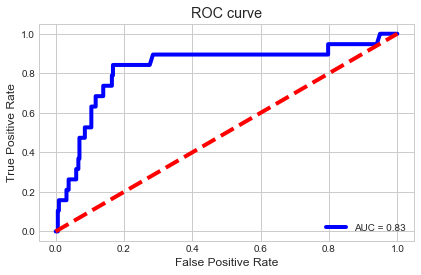

In [576]:
prob = clf.predict_proba(X_test)
preds = prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [577]:
np.set_printoptions(threshold=np.nan)
np.append(prob, y_test.values.reshape(335,1), axis=1)
pred_train = clf.predict_proba(X_train)

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


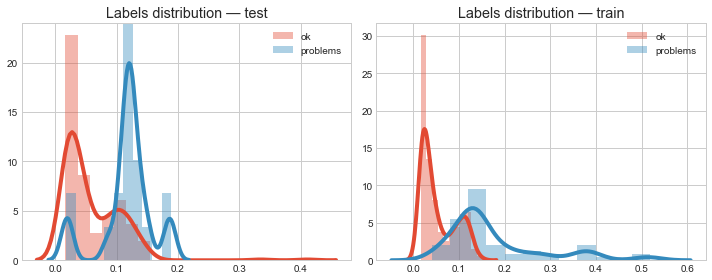

In [578]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
new_prob = np.append(prob, y_test.values.reshape(335,1), axis=1)
ax = sns.distplot(new_prob[new_prob[:, 2] == 0][:, 1], label='ok')
ax = sns.distplot(new_prob[new_prob[:, 2] == 1][:, 1], label = 'problems')
ax.legend()
ax.set_title('Labels distribution — test')

plt.subplot(1, 2, 2)
new_prob = np.append(pred_train, y_train.values.reshape(1005,1), axis=1)
ax = sns.distplot(new_prob[new_prob[:, 2] == 0][:, 1], label='ok')
ax = sns.distplot(new_prob[new_prob[:, 2] == 1][:, 1], label = 'problems')
ax.legend()
ax.set_title('Labels distribution — train')

plt.tight_layout()

Второй горб

In [580]:
new_prob = np.append(prob, y_test.values.reshape(335,1), axis=1)
new_prob_ix = np.append(new_prob, y_test.index.values.reshape(335, 1), axis=1)

new_prob_tr = np.append(pred_train, y_train.values.reshape(1005,1), axis=1)
new_prob_tr_ix = np.append(new_prob_tr, y_train.index.values.reshape(1005,1), axis=1)

ok_susp = new_prob_ix[np.logical_and(new_prob_ix[:, 2] == 0, new_prob_ix[:, 1] > 0.07)]
ok_susp_tr = new_prob_tr_ix[np.logical_and(new_prob_tr_ix[:, 2] == 0, new_prob_tr_ix[:, 1] > 0.07)]
df_copy = df.copy()
df_copy.loc[ok_susp[:, 3], 'all_pr'] = 2
df_copy.loc[ok_susp_tr[:, 3], 'all_pr'] = 2

In [581]:
df_copy[df_copy.all_pr == 2].index

Int64Index([ 138,  249,  444,  447,  448,  449,  450,  452,  455,  456,
            ...
            1286, 1287, 1289, 1291, 1301, 1303, 1304, 1308, 1309, 1312],
           dtype='int64', length=395)

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/cbook

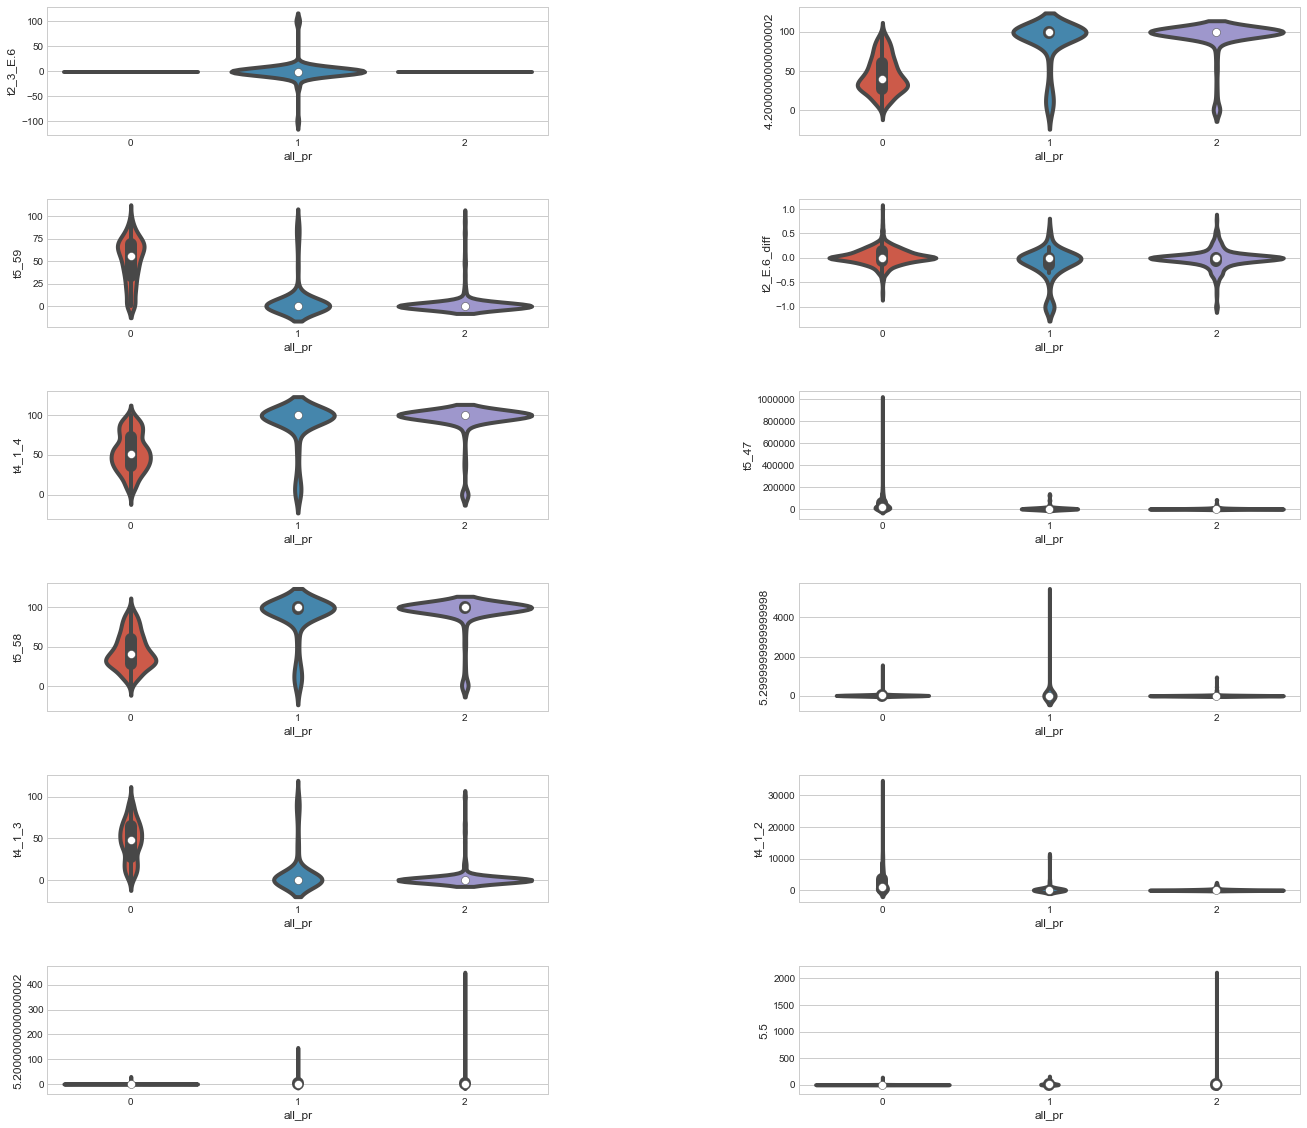

In [582]:
plot_cols = ['t2_3_E.6', '4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_3', 't4_1_2', '5.2000000000000002', '5.5']

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range (1, 13):
    plt.subplot(6, 2, i)
    ax = fig.add_subplot(6, 2, i)
    ax = sns.violinplot(x=df_copy['all_pr'], y=df_copy[plot_cols[i-1]])

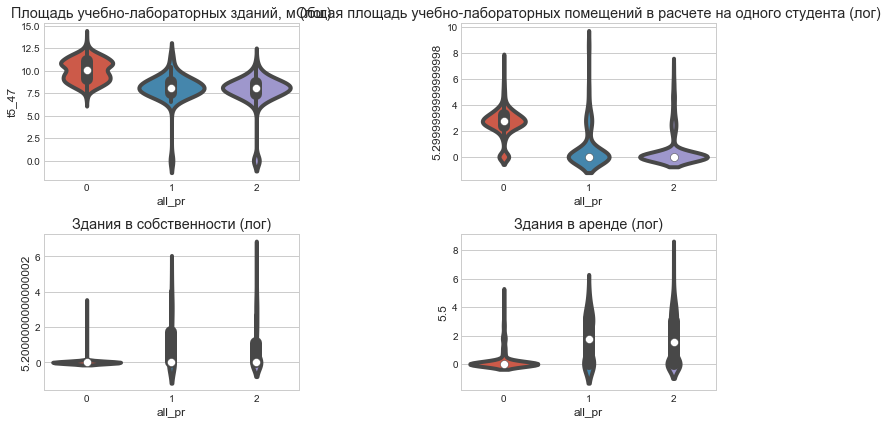

In [583]:
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(2, 2, 1)
ax = sns.violinplot(x=df_copy['all_pr'], y=np.log(df_copy['t5_47'] + 1))
ax.set_title('Площадь учебно-лабораторных зданий, м (лог)')

plt.subplot(2, 2, 2)
ax = sns.violinplot(x=df_copy['all_pr'], y=np.log(df_copy['5.2999999999999998'] + 1))
ax.set_title('Общая площадь учебно-лабораторных помещений в расчете на одного студента (лог)')

plt.subplot(2, 2, 3)
ax = sns.violinplot(x=df_copy['all_pr'], y=np.log(df_copy['5.2000000000000002'] + 1))
ax.set_title('Здания в собственности (лог)')

plt.subplot(2, 2, 4)
ax = sns.violinplot(x=df_copy['all_pr'], y=np.log(df_copy['5.5'] + 1))
ax.set_title('Здания в аренде (лог)')

plt.tight_layout()

In [584]:
def clf_result(y_test, y_pred_test, y_train, y_pred_train, trs):
    lst_test_acc = []
    lst_train_acc = []
    lst_test_pr = []
    lst_train_pr = []
    lst_test_rc = []
    lst_train_rc = []
    lst_test_f1 = []
    lst_train_f1 = []
    for i in trs:
        new_pred_test = (y_pred_test > i).astype(int)
        lst_test_acc.append(accuracy_score(y_test, new_pred_test))
        lst_test_pr.append(precision_score(y_test, new_pred_test))
        lst_test_rc.append(recall_score(y_test, new_pred_test))
        lst_test_f1.append(f1_score(y_test, new_pred_test))
            
        new_pred_train = (y_pred_train > i).astype(int)
        lst_train_acc.append(accuracy_score(y_train, new_pred_train))
        lst_train_pr.append(precision_score(y_train, new_pred_train))
        lst_train_rc.append(recall_score(y_train, new_pred_train))
        lst_train_f1.append(f1_score(y_train, new_pred_train))
        
    fig = plt.figure(figsize=(12,6))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    plt.subplot(2, 2, 1)
    plt.plot(lst_test_acc)
    plt.plot(lst_train_acc)
    plt.xticks(np.arange(len(trs)), trs)
    plt.legend(('test', 'train'))
    plt.title('Accuracy score')
    plt.xlabel('cutoff')
    plt.ylabel('accuracy')
    
    plt.subplot(2, 2, 2)
    ax = plt.plot(lst_test_f1)
    ax = plt.plot(lst_train_f1)
    plt.xticks(np.arange(len(trs)), trs)
    plt.legend(('test', 'train'))
    plt.title('F1 score')
    plt.xlabel('cutoff')
    plt.ylabel('F1')
    
    plt.subplot(2, 2, 3)
    ax = plt.plot(lst_test_rc)
    ax = plt.plot(lst_train_rc)
    plt.xticks(np.arange(len(trs)), trs)
    plt.legend(('test', 'train'))
    plt.title('Recall score')
    plt.xlabel('cutoff')
    plt.ylabel('recall')
    
    plt.subplot(2, 2, 4)
    ax = plt.plot(lst_test_pr)
    ax = plt.plot(lst_train_pr)
    plt.xticks(np.arange(len(trs)), trs)
    plt.legend(('test', 'train'))
    plt.title('Precision score')
    plt.xlabel('cutoff')
    plt.ylabel('precision')
    
    plt.tight_layout();

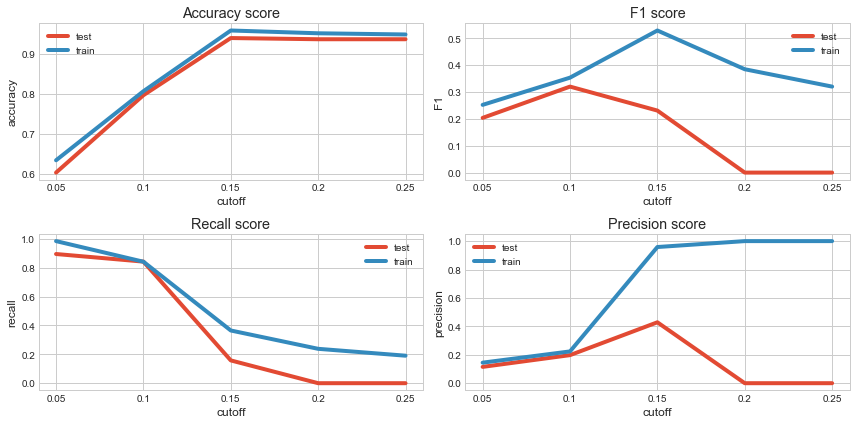

In [585]:
clf_result(y_test, prob[:, 1], y_train, pred_train[:, 1], [0.05, 0.1, 0.15, 0.2, 0.25])

1. t2_3_E.6,"Трудоустройство, Изменение относительно прошлого года"
2. 4.2000000000000002,"Доля доходов из средств от приносящей доход деятельности в доходах по всем видам финансового обеспечения (деятельности) образовательной организации, %"
3. t5_59,"Доля доходов филиала  из федерального бюджета, %"
4. t2_E.6_diff Трудоустройство, отклонение от порога
5. t5_47,"Площадь учебно-лабораторных зданий, м"
6. t4_1_4 % обучающихся по договорам платных услуг
7. t5_58,"Доля доходов филиала  из внебюджетных источников, %"
8. 5.2999999999999998,"Общая площадь учебно-лабораторных помещений в расчете на одного студента (приведенного контингента), закрепленных на праве оперативного управления, м"
9. t4_1_3 за счет бюджетных ассигнований
10. t4_1_2 студентов очной формы обучения
11. t2_E.3_diff отклонение по международной деятельности

In [586]:
importances = list(zip(clf.feature_importances_, X_train.columns))
importances.sort(reverse=True)
importances

[(0.07032500539152607, 't2_3_E.6'),
 (0.05144327683644324, 't4_4_080000_2'),
 (0.047830631140981066, '4.2000000000000002'),
 (0.047583680870133024, 't4_4_030000_2'),
 (0.043815953535548485, 't5_59'),
 (0.04132947508150984, 't4_4_030000_1'),
 (0.037166777238174416, 't2_E.6_diff'),
 (0.035108320241908, 't4_1_4'),
 (0.030839232009999763, 't4_4_080000_1'),
 (0.024420740529324688, 't5_47'),
 (0.024047362156540762, 't5_58'),
 (0.0225638311457779, '5.2999999999999998'),
 (0.0200290357015226, 't4_1_3'),
 (0.01990223377683564, 't4_1_2'),
 (0.01859677482777861, 't4_4_030000_3'),
 (0.018405117445491205, '5.2000000000000002'),
 (0.018316066841587805, '5.5'),
 (0.017704279379906308, 't2_E.3_diff'),
 (0.01737692158886986, '1.7'),
 (0.015852139285264896, '2.2999999999999998'),
 (0.015780807672651786, 't5_52'),
 (0.014553550848107149, '1.2'),
 (0.013427687629256177, '1.1000000000000001'),
 (0.0119315047465424, 't5_63'),
 (0.011311286318768963, 't5_46'),
 (0.010690303862175465, 't4_1_1'),
 (0.010584747

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/cbook

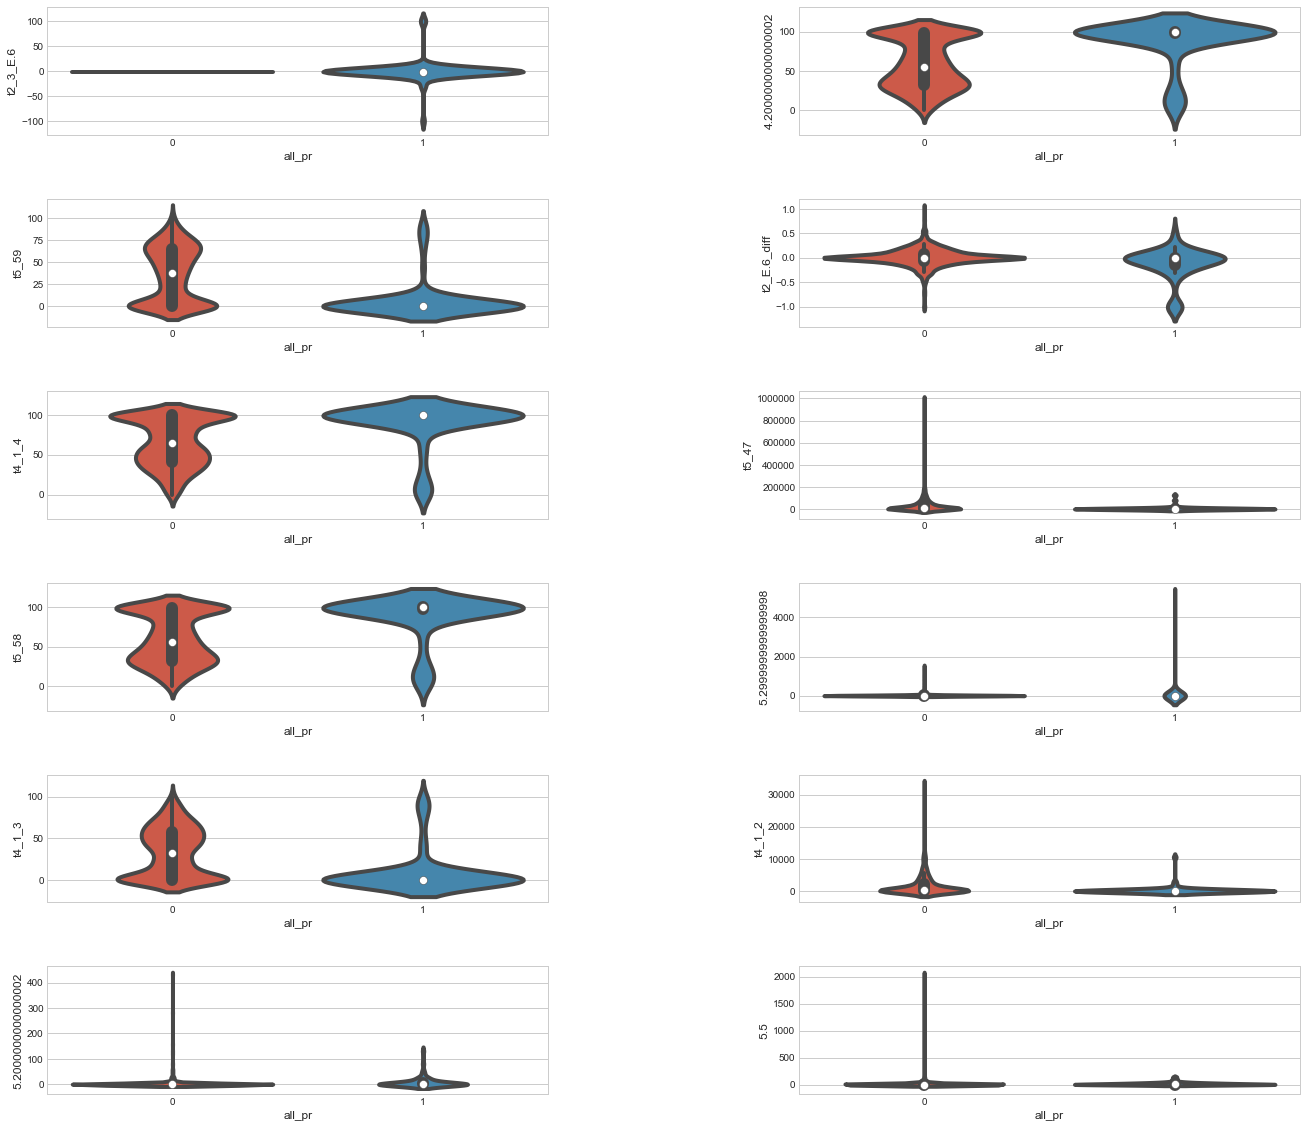

In [587]:
plot_cols = ['t2_3_E.6', '4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_3', 't4_1_2', '5.2000000000000002', '5.5']

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range (1, 13):
    plt.subplot(6, 2, i)
    ax = fig.add_subplot(6, 2, i)
    ax = sns.violinplot(x=df['all_pr'], y=df[plot_cols[i-1]])

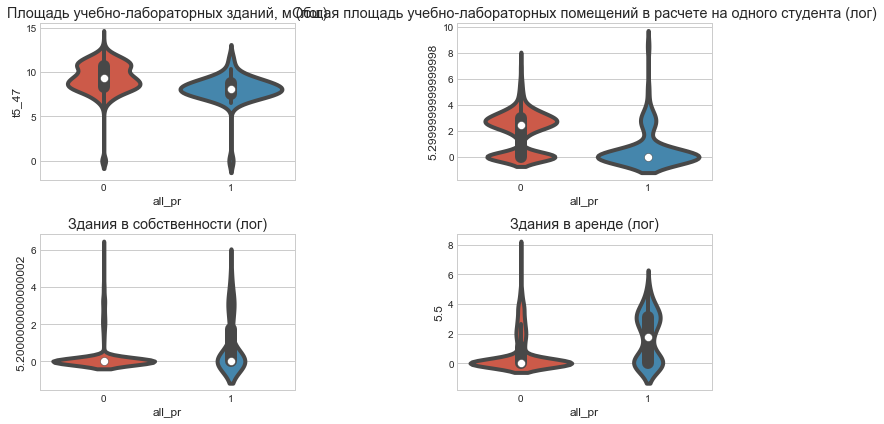

In [588]:
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(2, 2, 1)
ax = sns.violinplot(x=df['all_pr'], y=np.log(df['t5_47'] + 1))
ax.set_title('Площадь учебно-лабораторных зданий, м (лог)')

plt.subplot(2, 2, 2)
ax = sns.violinplot(x=df['all_pr'], y=np.log(df['5.2999999999999998'] + 1))
ax.set_title('Общая площадь учебно-лабораторных помещений в расчете на одного студента (лог)')

plt.subplot(2, 2, 3)
ax = sns.violinplot(x=df['all_pr'], y=np.log(df['5.2000000000000002'] + 1))
ax.set_title('Здания в собственности (лог)')

plt.subplot(2, 2, 4)
ax = sns.violinplot(x=df['all_pr'], y=np.log(df['5.5'] + 1))
ax.set_title('Здания в аренде (лог)')

plt.tight_layout()

RF с меткой по второму горбу

In [589]:
# убираем текстовые переменные
X_new = df.drop(['address', 'comment', 'comment_date', 'name', 'response', 'status',
       't1_3', 't1_4', 't1_5', 't1_6', 't1_7', 'all_pr', 'det_pr'], axis=1)
# убираем бенчмарки
drop_col = [col for col in df if col.startswith('t2_2_')]
X_new = X_new.drop(drop_col, axis = 1)
# добавляем новый признак
idx = np.hstack([ok_susp[:, 3], ok_susp_tr[:, 3]])
zeros = pd.Series(data=np.zeros(X_new.shape[0]))
zeros.loc[idx] = 1
X_new['ok_susp'] = zeros

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_new, df['all_pr'], 
                                                    test_size=0.25, random_state=35, shuffle=True)

In [590]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(X_train_n, y_train_n)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Text(0.5,0,'False Positive Rate')

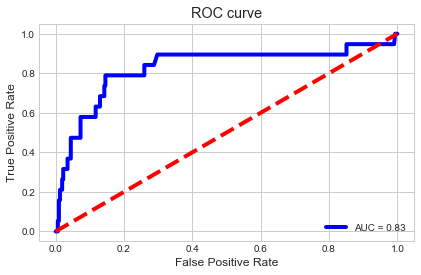

In [591]:
prob = clf.predict_proba(X_test_n)
preds = prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test_n, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

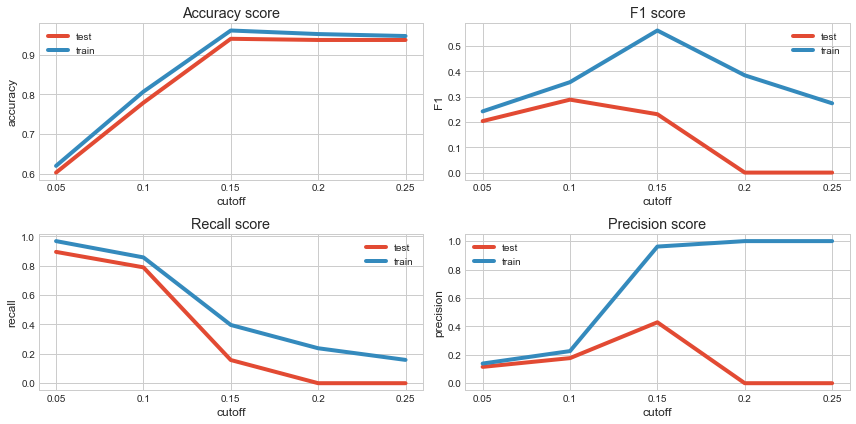

In [595]:
prob = clf.predict_proba(X_test_n)
pred_train = clf.predict_proba(X_train_n)

clf_result(y_test_n, prob[:, 1], y_train_n, pred_train[:, 1], [0.05, 0.1, 0.15, 0.2, 0.25])

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


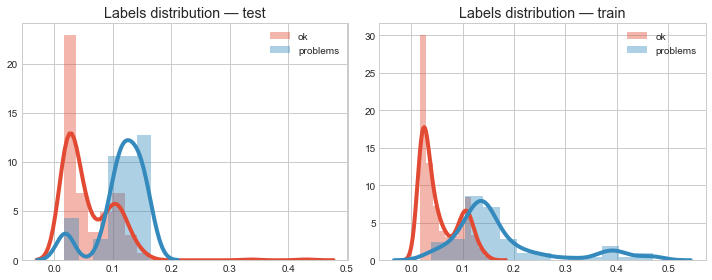

In [596]:
np.set_printoptions(threshold=np.nan)
np.append(prob, y_test_n.values.reshape(335,1), axis=1)
pred_train = clf.predict_proba(X_train_n)
fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
new_prob = np.append(prob, y_test_n.values.reshape(335,1), axis=1)
ax = sns.distplot(new_prob[new_prob[:, 2] == 0][:, 1], label='ok')
ax = sns.distplot(new_prob[new_prob[:, 2] == 1][:, 1], label = 'problems')
ax.legend()
ax.set_title('Labels distribution — test')

plt.subplot(1, 2, 2)
new_prob = np.append(pred_train, y_train_n.values.reshape(1005,1), axis=1)
ax = sns.distplot(new_prob[new_prob[:, 2] == 0][:, 1], label='ok')
ax = sns.distplot(new_prob[new_prob[:, 2] == 1][:, 1], label = 'problems')
ax.legend()
ax.set_title('Labels distribution — train')

plt.tight_layout()

In [597]:
importances = list(zip(clf.feature_importances_, X_train_n.columns))
importances.sort(reverse=True)
importances

[(0.07146420993687173, 't4_4_030000_2'),
 (0.06123738279735214, 't5_59'),
 (0.04871285607811026, 't4_4_080000_2'),
 (0.044671293194769444, 't2_3_E.6'),
 (0.04198150114157959, 't5_63'),
 (0.041682485857730454, 't2_E.6_diff'),
 (0.03391647482733779, '4.2000000000000002'),
 (0.029503349753308195, '1.1000000000000001'),
 (0.02324610954005693, 't4_4_030000_1'),
 (0.019677787838807772, 't4_1_4'),
 (0.018681705128145626, 't4_1_1'),
 (0.018209265960243793, 't5_52'),
 (0.017497523145417516, '1.2'),
 (0.01741814942972264, 't2_E.3_diff'),
 (0.016787520137514358, 't4_4_37.00.00_2'),
 (0.016196124718984063, 't5_47'),
 (0.015558076018711271, 't4_4_080000_3'),
 (0.015199397876338411, 't4_4_080000_1'),
 (0.015146249575658704, 't2_1_E.6'),
 (0.014278931779942385, 't4_1_2'),
 (0.013304586915573563, 't2_3_E.3'),
 (0.012300254233870125, 't4_4_030000_3'),
 (0.011834317938054497, 't5_58'),
 (0.011038763753680849, '2.1499999999999999'),
 (0.01070092785426251, 't2_1_E.1'),
 (0.010607180687840834, 't4_1_3'),
 

In [598]:
df[X_new.ok_susp == 1]['name'][138] # 2 показателя

'Федеральное государственное бюджетное образовательное учреждение высшего образования "Пущинский государственный естественно-научный институт"'

In [599]:
df[X_new.ok_susp == 1]['name'][249] # 2 показателя

'Оренбургский филиал федерального государственного бюджетного образовательного учреждения высшего образования "Поволжский государственный университете телекоммуникаций и информатики"'

In [600]:
df[X_new.ok_susp == 1]['name'][444] # все ок

'Негосударственное аккредитованное некоммерческое частное образовательное учреждение высшего образования «Академия маркетинга и социально-информационных технологий – ИМСИТ» (г. Краснодар) (НАН ЧОУ ВО Академия ИМСИТ)'

In [601]:
df[X_new.ok_susp == 1]['name'][447] # 1 показатель

'Частное образовательное учреждение высшего образования "Балтийская академия туризма и предпринимательства"'

In [602]:
df[X_new.ok_susp == 1]['name'][448] # 2 показателя

'Автономная некоммерческая организация высшего образования "Московский гуманитарный институт"'

In [603]:
df[X_new.ok_susp == 1]['name'][449] # 1 показатель

'Автономная некоммерческая организация высшего образования "Международный банковский институт"'

In [604]:
 df[X_new.ok_susp == 1]['name'][450] # 1 показатель

'Частная образовательная организация высшего образования "Социально-педагогический институт"'

#### Логит на фичах из RF

In [605]:
logit_model = sm.Logit(y_train, X_train[['4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_2', '5.2000000000000002']])
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.189105
         Iterations 11


/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/Users/ola/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/ola/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/ola/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: Logit
==============================================================================================================
Model:                             Logit                           Pseudo R-squared:                0.193     
Dependent Variable:                all_pr                          AIC:                             396.1012  
Date:                              2019-04-08 09:51                BIC:                             435.4031  
No. Observations:                  1005                            Log-Likelihood:                  -190.05   
Df Model:                          7                               LL-Null:                         -235.47   
Df Residuals:                      997                             LLR p-value:                     8.3358e-17
Converged:                         1.0000                          Scale:                           1.0000    
No. Iterations:                    11.0000                                                                    
--------------------------------------------------------------------------------------------------------------
                    Coef.        Std.Err.             z        P>|z|         [0.025               0.975]      
--------------------------------------------------------------------------------------------------------------
4.2000000000000002  0.0020 20740934730307.9141          0.0000 1.0000 -40651485077099.4922 40651485077099.4922
t5_59              -0.0484              0.0000 -137934748.3191 0.0000              -0.0484             -0.0484
t2_E.6_diff        -2.4024              0.5321         -4.5151 0.0000              -3.4453             -1.3596
t4_1_4             -0.0230                 nan             nan    nan                  nan                 nan
t5_47               0.0000              0.0000          0.0797 0.9365              -0.0001              0.0001
t5_58               0.0020 20740934730307.9570          0.0000 1.0000 -40651485077099.5781 40651485077099.5781
5.2999999999999998  0.0008              0.0006          1.2953 0.1952              -0.0004              0.0020
t4_1_2             -0.0012              0.0006         -1.9661 0.0493              -0.0024             -0.0000
5.2000000000000002  0.0075              0.0058          1.2975 0.1945              -0.0038              0.0189
==============================================================================================================

"""

Text(0.5,0,'False Positive Rate')

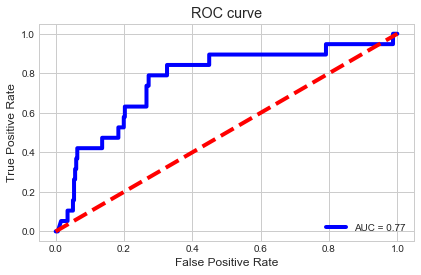

In [606]:
prob = result.predict(X_test[['4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_2', '5.2000000000000002']])
prob_train = result.predict(X_train[['4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_2', '5.2000000000000002']])
fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


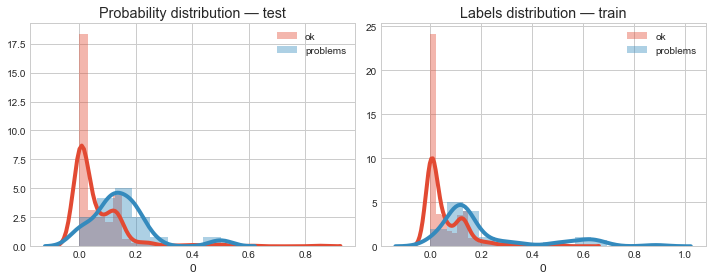

In [607]:
new_pred_logit = pd.concat([prob, y_test], axis=1)
new_pred_logit_tr = pd.concat([prob_train, y_train], axis=1)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ax = sns.distplot(new_pred_logit[new_pred_logit['all_pr'] == 0][0], label='ok')
ax = sns.distplot(new_pred_logit[new_pred_logit['all_pr'] == 1][0], label = 'problems')
ax.legend()
ax.set_title('Probability distribution — test')

plt.subplot(1, 2, 2)
ax = sns.distplot(new_pred_logit_tr[new_pred_logit_tr['all_pr'] == 0][0], label='ok')
ax = sns.distplot(new_pred_logit_tr[new_pred_logit_tr['all_pr'] == 1][0], label = 'problems')
ax.legend()
ax.set_title('Labels distribution — train')

plt.tight_layout()

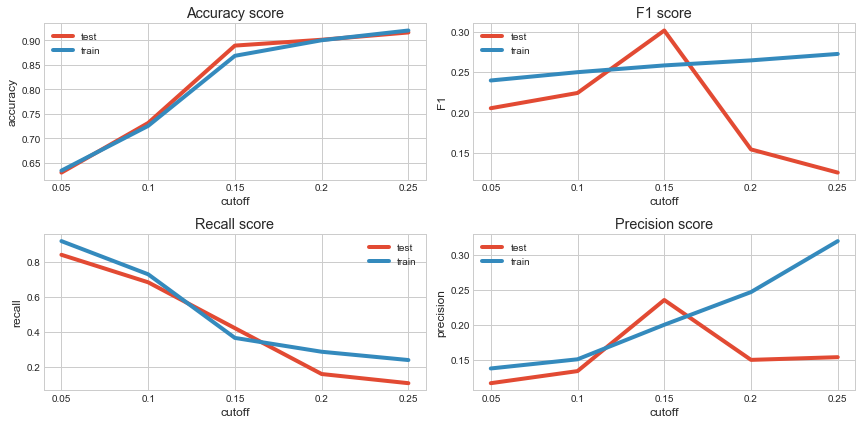

In [608]:
clf_result(y_test, prob, y_train, prob_train, [0.05, 0.1, 0.15, 0.2, 0.25])

#### Логит на фичах RF + ok_susp

In [609]:
logit_model = sm.Logit(y_train_n, X_train_n[['4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_2', '5.2000000000000002', 'ok_susp']])
result = logit_model.fit()
result.summary2()

         Current function value: 0.089279
         Iterations: 35


LinAlgError: Singular matrix

#### Логит на подобранных фичах

In [610]:
logit_model_2 = sm.Logit(y_train, X_train[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2']])
result = logit_model_2.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.179352
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:               Logit            Pseudo R-squared: 0.235     
Dependent Variable:  all_pr           AIC:              376.4983  
Date:                2019-04-08 09:52 BIC:              415.8002  
No. Observations:    1005             Log-Likelihood:   -180.25   
Df Model:            7                LL-Null:          -235.47   
Df Residuals:        997              LLR p-value:      7.4492e-21
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      10.0000                                      
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
t5_59              -0.0312   0.0090 -3.4789 0.0005 -0.0488 -0.0136
t2_E.6_diff        -2.1489   0.5521 -3.8920 0.0001 -3.2311 -1.0668
1.2                -0.0173   0.0079 -2.1928 0.0283 -0.0327 -0.0018
t2_1_E.7           -0.0043   0.0016 -2.7380 0.0062 -0.0075 -0.0012
4.0999999999999996 -0.0002   0.0001 -1.3992 0.1618 -0.0004  0.0001
7.2999999999999998  0.0037   0.0070  0.5251 0.5995 -0.0100  0.0173
t4_1_4             -0.0145   0.0061 -2.3769 0.0175 -0.0264 -0.0025
t4_1_2             -0.0007   0.0004 -1.8651 0.0622 -0.0014  0.0000
==================================================================

"""

In [611]:
pred_logit =  result.predict(X_test[['t5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', 
                                     '4.0999999999999996', '7.2999999999999998', 
                                     't4_1_4', 't4_1_2']])
pred_logit_tr =  result.predict(X_train[['t5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', 
                                     '4.0999999999999996', '7.2999999999999998', 
                                     't4_1_4', 't4_1_2']])

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


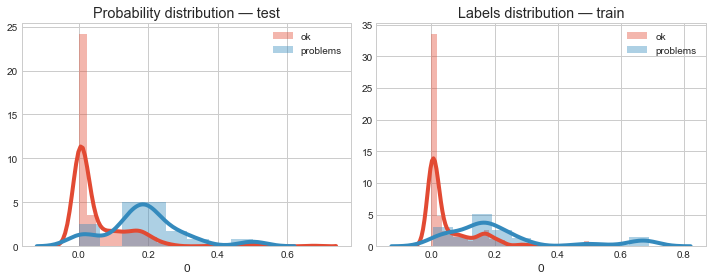

In [612]:
new_pred_logit = pd.concat([pred_logit, y_test], axis=1)
new_pred_logit_tr = pd.concat([pred_logit_tr, y_train], axis=1)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ax = sns.distplot(new_pred_logit[new_pred_logit['all_pr'] == 0][0], label='ok')
ax = sns.distplot(new_pred_logit[new_pred_logit['all_pr'] == 1][0], label = 'problems')
ax.legend()
ax.set_title('Probability distribution — test')

plt.subplot(1, 2, 2)
ax = sns.distplot(new_pred_logit_tr[new_pred_logit_tr['all_pr'] == 0][0], label='ok')
ax = sns.distplot(new_pred_logit_tr[new_pred_logit_tr['all_pr'] == 1][0], label = 'problems')
ax.legend()
ax.set_title('Labels distribution — train')

plt.tight_layout()

Text(0.5,0,'False Positive Rate')

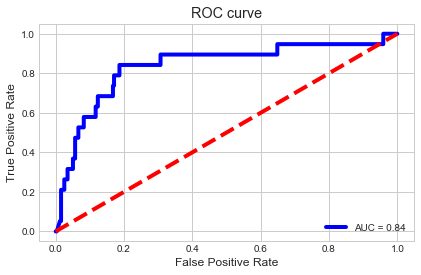

In [613]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_logit)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

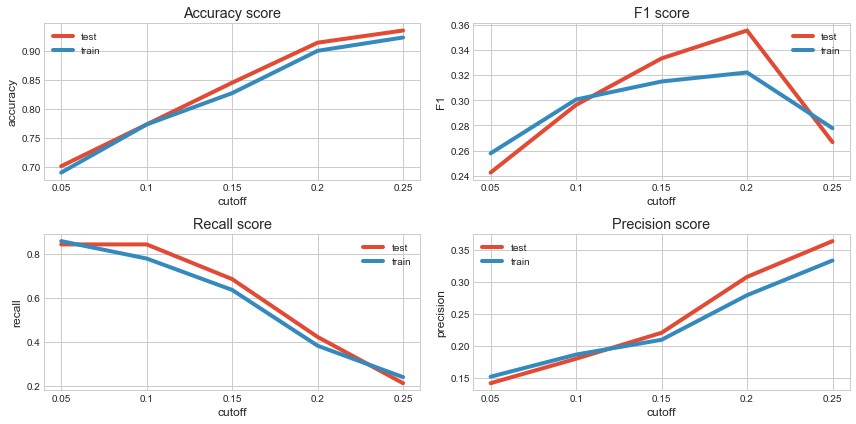

In [614]:
clf_result(y_test, pred_logit, y_train, pred_logit_tr, [0.05, 0.1, 0.15, 0.2, 0.25])

In [615]:
# new_pred_logit

In [616]:
final_pred_logit = (pred_logit > 0.15).astype(int)
print(classification_report(y_test, final_pred_logit))

             precision    recall  f1-score   support

          0       0.98      0.85      0.91       316
          1       0.22      0.68      0.33        19

avg / total       0.94      0.84      0.88       335



In [617]:
df.loc[543]['name'] # не выполнено три показателя

'Автономная некоммерческая организация высшего образования "Институт экономики и управления"'

In [618]:
df.loc[491]['name'] # проверить статус! нет в мониторинге 2018

'Негосударственное частное образовательное учреждение высшего образования "Северный институт предпринимательства"'

In [619]:
df.loc[885]['name'] # 5 показателей

'Филиал федерального государственного бюджетного образовательного учреждения высшего образования "Удмуртский государственный университет" в городе Нижняя Тура'

In [620]:
df.loc[936]['name'] # 3 показателя

'Филиал образовательного учреждения профессионального образования "Санкт-Петербургский институт внешнеэкономических связей, экономики и права" в г.Краснодаре '

In [621]:
df.loc[861]['name'] # 3 показателя

'Филиал федерального государственного бюджетного образовательного учреждения высшего образования "Ростовский государственный экономический университет (РИНХ)" в г.Махачкале Республики Дагестан'

Вероятности логитов

In [624]:
logit_model = sm.Logit(y_train, X_train[['4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_2', '5.2000000000000002']])
result = logit_model.fit()

prob = result.predict(X_test[['4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_2', '5.2000000000000002']])
prob_train = result.predict(X_train[['4.2000000000000002', 't5_59', 't2_E.6_diff', 't4_1_4', 't5_47', 't5_58',
            '5.2999999999999998', 't4_1_2', '5.2000000000000002']])
new_prob_logit = pd.concat([prob, y_test], axis=1)
new_prob_logit_tr = pd.concat([prob_train, y_train], axis=1)

logit_model_2 = sm.Logit(y_train, X_train[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2']])
result_2 = logit_model_2.fit()

pred_logit =  result_2.predict(X_test[['t5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', 
                                     '4.0999999999999996', '7.2999999999999998', 
                                     't4_1_4', 't4_1_2']])
pred_logit_tr =  result_2.predict(X_train[['t5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', 
                                     '4.0999999999999996', '7.2999999999999998', 
                                     't4_1_4', 't4_1_2']])
new_pred_logit = pd.concat([pred_logit, y_test], axis=1)
new_pred_logit_tr = pd.concat([pred_logit_tr, y_train], axis=1)

Optimization terminated successfully.
         Current function value: 0.189105
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.179352
         Iterations 10


Text(0.5,1,'RF and man logit p hat diff')

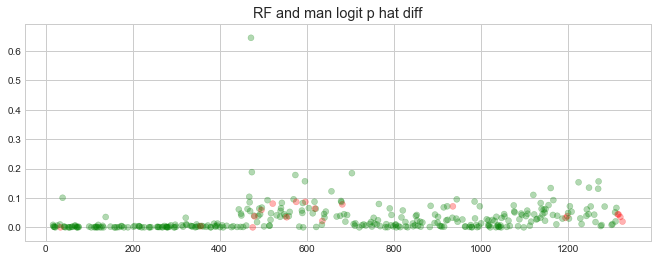

In [649]:
fig = plt.figure(figsize=(10, 4))
plt.scatter(x=prob.index, y=abs(prob - pred_logit), alpha=0.3, c=new_prob_logit['all_pr'], 
            cmap=matplotlib.colors.ListedColormap(['green', 'red']))
plt.title('RF and man logit p hat diff')

In [645]:
import matplotlib

#### Логит на подобранных фичах + ok_susp

In [650]:
logit_model_2 = sm.Logit(y_train_n, X_train_n[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2', 'ok_susp']])
result = logit_model_2.fit()
result.summary2()

         Current function value: 0.069706
         Iterations: 35


/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                  Logit               Pseudo R-squared:    0.702     
Dependent Variable:     all_pr              AIC:                 158.1100  
Date:                   2019-04-08 10:00    BIC:                 202.3247  
No. Observations:       1005                Log-Likelihood:      -70.055   
Df Model:               8                   LL-Null:             -235.47   
Df Residuals:           996                 LLR p-value:         1.1155e-66
Converged:              0.0000              Scale:               1.0000    
No. Iterations:         35.0000                                            
---------------------------------------------------------------------------
                    Coef.    Std.Err.    z    P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------
t5_59               -0.0553    0.0119 -4.6648 0.0000     -0.0786    -0.0321
t2_E.6_diff         -1.9745    1.0775 -1.8325 0.0669     -4.0864     0.1374
1.2                 -0.0285    0.0083 -3.4213 0.0006     -0.0448    -0.0122
t2_1_E.7            -0.0082    0.0020 -4.0735 0.0000     -0.0122    -0.0043
4.0999999999999996  -0.0002    0.0002 -1.2586 0.2082     -0.0006     0.0001
7.2999999999999998   0.0048    0.0116  0.4138 0.6791     -0.0180     0.0276
t4_1_4               0.0212    0.0110  1.9216 0.0547     -0.0004     0.0428
t4_1_2              -0.0013    0.0005 -2.5504 0.0108     -0.0024    -0.0003
ok_susp            -25.4752 9668.5534 -0.0026 0.9979 -18975.4916 18924.5412
===========================================================================

"""

Text(0.5,0,'False Positive Rate')

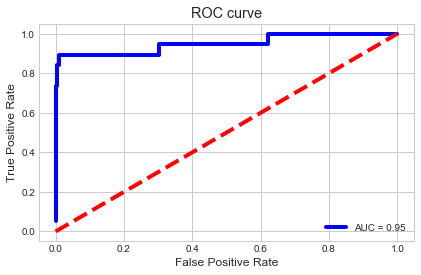

In [651]:
pred_logit =  result.predict(X_test_n[['t5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', 
                                     '4.0999999999999996', '7.2999999999999998', 
                                     't4_1_4', 't4_1_2', 'ok_susp']])
pred_logit_tr =  result.predict(X_train_n[['t5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', 
                                     '4.0999999999999996', '7.2999999999999998', 
                                     't4_1_4', 't4_1_2', 'ok_susp']])

fpr, tpr, threshold = metrics.roc_curve(y_test_n, pred_logit)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


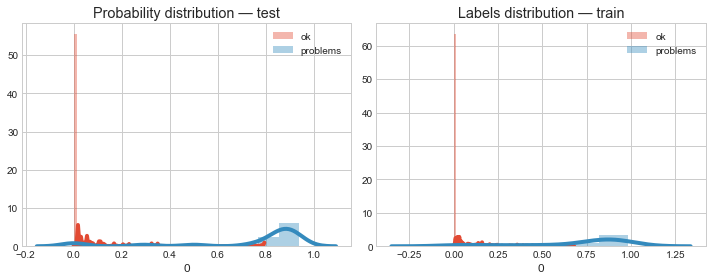

In [652]:
new_pred_logit = pd.concat([pred_logit, y_test_n], axis=1)
new_pred_logit_tr = pd.concat([pred_logit_tr, y_train_n], axis=1)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ax = sns.distplot(new_pred_logit[new_pred_logit['all_pr'] == 0][0], label='ok')
ax = sns.distplot(new_pred_logit[new_pred_logit['all_pr'] == 1][0], label = 'problems')
ax.legend()
ax.set_title('Probability distribution — test')

plt.subplot(1, 2, 2)
ax = sns.distplot(new_pred_logit_tr[new_pred_logit_tr['all_pr'] == 0][0], label='ok')
ax = sns.distplot(new_pred_logit_tr[new_pred_logit_tr['all_pr'] == 1][0], label = 'problems')
ax.legend()
ax.set_title('Labels distribution — train')

plt.tight_layout()

In [653]:
pred_logit.sort_values(ascending=False)

576     9.377707e-01
936     9.220505e-01
597     9.204677e-01
554     9.100626e-01
682     8.986599e-01
636     8.890555e-01
1317    8.874261e-01
619     8.863437e-01
522     8.704852e-01
1195    8.612211e-01
480     8.503809e-01
1199    8.484214e-01
1321    8.131637e-01
1315    8.119225e-01
605     7.922026e-01
496     7.413036e-01
476     5.000000e-01
1285    3.501586e-01
851     3.248855e-01
1326    2.924913e-01
686     2.320897e-01
902     2.031728e-01
781     1.672275e-01
704     1.284053e-01
745     1.231347e-01
679     1.149747e-01
992     1.113687e-01
849     1.083487e-01
1264    1.073435e-01
764     1.066908e-01
689     8.327687e-02
657     7.765583e-02
461     7.412912e-02
1036    7.153037e-02
1310    6.748176e-02
1225    5.658126e-02
322     5.652809e-02
795     5.455983e-02
454     5.427687e-02
1249    5.000747e-02
923     4.540941e-02
901     3.714637e-02
821     3.078104e-02
502     3.013904e-02
990     2.835321e-02
908     2.689128e-02
1032    2.417861e-02
845     2.309

In [654]:
df.loc[998]['name'] # 2

'Воронежский филиал Федерального государственного бюджетного образовательного учреждения высшего образования "Государственный университет морского и речного флота имени адмирала С.О. Макарова"'

In [655]:
df.loc[540]['name'] # 3

'Частное образовательное учреждение высшего образования "Владикавказский институт управления"'

In [656]:
df.loc[355]['name'] # 0

'федеральное государственное бюджетное образовательное учреждение высшего образования «Хабаровский государственный институт культуры»'

In [657]:
df.loc[333]['name'] # 1

'федеральное государственное бюджетное образовательное учреждение высшего образования "Екатеринбургский государственный театральный институт"'

In [658]:
df.loc[693]['name'] # 2

'Негосударственное образовательное учреждение высшего образования "Столичная финансово-гуманитарная академия"'

#### KNN

In [659]:
scaler = MinMaxScaler()
X = df.drop(['address', 'comment', 'comment_date', 'name', 'response', 'status',
       't1_3', 't1_4', 't1_5', 't1_6', 't1_7', 'all_pr', 'det_pr'], axis=1)
drop_col = [col for col in df if col.startswith('t2_2_')]
X = X.drop(drop_col, axis = 1)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, df['all_pr'], 
                                                    test_size=0.25, random_state=35, shuffle=True)

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_sc, y_train_sc)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [660]:
knn.predict(X_test_sc)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


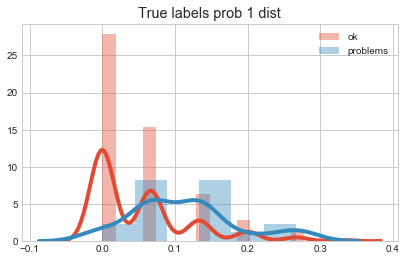

In [661]:
knn_prob = knn.predict_proba(X_test_sc)
new_knn_prob = np.append(knn_prob, y_test.values.reshape(335,1), axis=1)

ax = sns.distplot(new_knn_prob[new_knn_prob[:, 2] == 0][:, 1], label='ok')
ax = sns.distplot(new_knn_prob[new_knn_prob[:, 2] == 1][:, 1], label = 'problems')
ax.legend()
ax.set_title('True labels prob 1 dist');

#### LASSO

In [315]:
ls = LassoCV(cv=5)
sfm = SelectFromModel(clf, threshold=0.03)
sfm.fit(X_train, y_train)
n_features = sfm.transform(X_train).shape[1]
while n_features > 10:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X_train)
    n_features = X_transform.shape[1]

In [316]:
feature_names = np.array(X_train.columns)
feature_names[sfm.get_support()]

array(['4.2000000000000002', 't2_3_E.6', 't4_1_4', 't4_4_030000_1',
       't4_4_030000_2', 't4_4_080000_1', 't4_4_080000_2', 't5_59',
       't2_E.6_diff'], dtype=object)

* 4.2000000000000002,"Доля доходов из средств от приносящей доход деятельности в доходах по всем видам финансового обеспечения (деятельности) образовательной организации, %"
* t2_3_E.6,"Трудоустройство, Изменение относительно прошлого года"
* t4_1_4 число платников
* t4_4_030000_1 доля студентов гуманитарного специалитета
* t4_4_080000_1 доля студентов экономического специалитета
* t5_59,"Доля доходов филиала  из федерального бюджета, %"
* t2_E.6_diff отклонение от показателя по трудовой деятельности

#### SVM

In [317]:
svm = SVC(probability=True, )
svm.fit(X_train, y_train)
preds = svm.predict_proba(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [318]:
svm = SVC(probability=True)
svm.fit(X_train[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2']], y_train)
preds = svm.predict_proba(X_test[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2']])

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Text(0.5, 0, 'False Positive Rate')

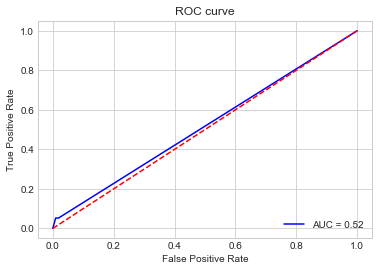

In [319]:
fpr, tpr, threshold = metrics.roc_curve(y_test, preds[:, 1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### DecisionTree

In [320]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [321]:
#dot_data = StringIO()
#export_graphviz(tree, out_file=dot_data,  
#                filled=True, rounded=True,
#                special_characters=True)
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

In [322]:
importances = list(zip(tree.feature_importances_, X_train.columns))
importances.sort(reverse=True)
importances

[(0.1806403855168361, 't2_3_E.6'),
 (0.12434283305288488, 't4_4_080000_2'),
 (0.05669041555511224, 't5_52'),
 (0.04172814759109907, 't5_59'),
 (0.038593364837807474, 't5_16'),
 (0.03727016375765408, 't5_26'),
 (0.031245707075073268, 't2_3_E.2'),
 (0.0282150003785255, 't4_4_45.00.00_2'),
 (0.027666278512094054, '7.4000000000000004'),
 (0.02675806628754652, 't2_1_E.5'),
 (0.025802421062991288, 't4_4_40.00.00_3'),
 (0.02330638266179285, '7.5'),
 (0.018625729584214806, '2.1000000000000001'),
 (0.0185269748143025, '2.1600000000000001'),
 (0.017102754191178147, '2.5'),
 (0.01690838245618062, '5.2000000000000002'),
 (0.016053150274719395, 't2_3_E.3'),
 (0.015785508332647087, 't2_E.2_diff'),
 (0.015670704635682105, 't4_4_51.00.00_2'),
 (0.01555714880498858, 't4_4_37.00.00_3'),
 (0.015444822820837426, 't4_4_54.00.00_1'),
 (0.015333708987593899, 't4_4_15.00.00_3'),
 (0.01522378992675074, '3.1000000000000001.1'),
 (0.01511504857013128, '4.4000000000000004'),
 (0.015051412286744918, 't4_4_21.00.00

Text(0.5, 0, 'False Positive Rate')

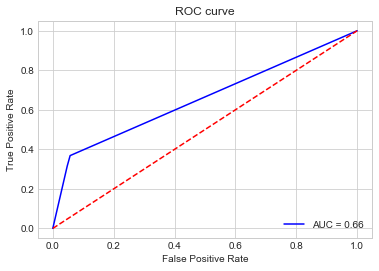

In [323]:
pred = tree.predict_proba(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred[:, 1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### XGBoost

In [518]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Text(0.5,0,'False Positive Rate')

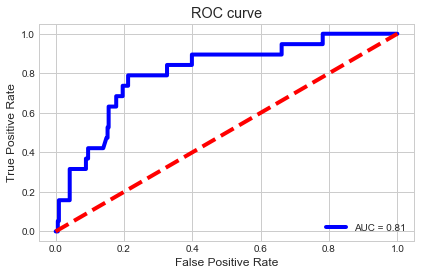

In [519]:
pred = gb.predict_proba(X_test)
pred_tr = gb.predict_proba(X_train)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred[:, 1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


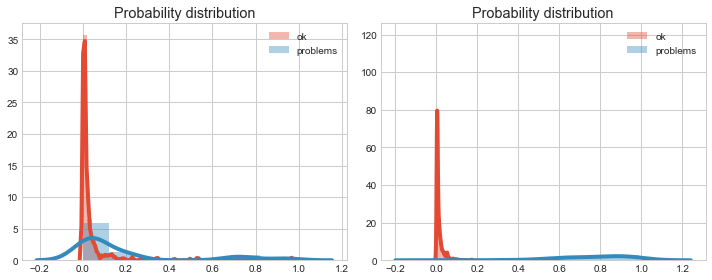

In [520]:
new_gb_prob = np.append(pred, y_test.values.reshape(335,1), axis=1)
new_gb_prob_tr = np.append(pred_tr, y_train.values.reshape(1005,1), axis=1)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ax = sns.distplot(new_gb_prob[new_gb_prob[:, 2] == 0][:, 1], label='ok')
ax = sns.distplot(new_gb_prob[new_gb_prob[:, 2] == 1][:, 1], label = 'problems')
ax.legend()
ax.set_title('Probability distribution')

plt.subplot(1, 2, 2)
ax = sns.distplot(new_gb_prob_tr[new_gb_prob_tr[:, 2] == 0][:, 1], label='ok')
ax = sns.distplot(new_gb_prob_tr[new_gb_prob_tr[:, 2] == 1][:, 1], label = 'problems')
ax.legend()
ax.set_title('Probability distribution')
plt.tight_layout()

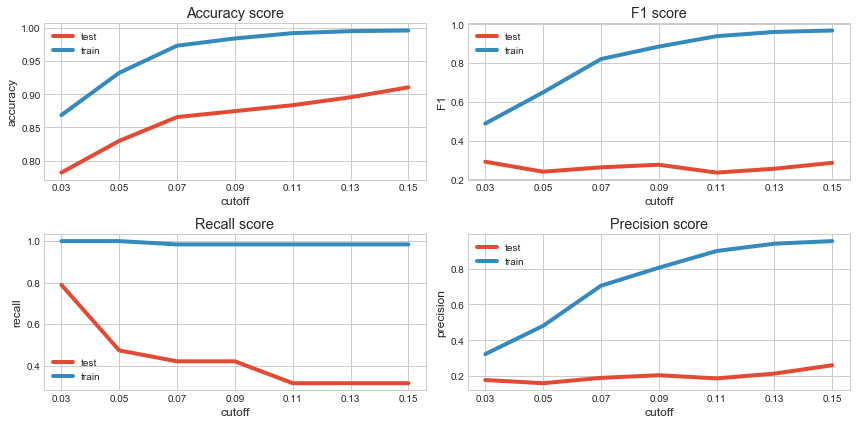

In [521]:
clf_result(y_test, pred[:, 1], y_train, pred_tr[:, 1], [0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15])

In [328]:
importances = list(zip(gb.feature_importances_, X_train.columns))
importances.sort(reverse=True)
importances

[(0.17191508999923424, 't2_3_E.6'),
 (0.13026539620241345, 't4_4_080000_2'),
 (0.06336832736200933, 't5_59'),
 (0.02546034579191098, 't2_3_E.8'),
 (0.022875183228383836, '2.2000000000000002'),
 (0.021580681473562145, '3.2000000000000002'),
 (0.020445027812640577, 't2_1_E.8'),
 (0.01847978315923006, '2.6000000000000001'),
 (0.017524289830685713, 't4_4_31.00.00_2'),
 (0.015633570089268144, 't2_3_E.1'),
 (0.01476333810341745, 't2_1_E.3'),
 (0.014673163393902169, '5.5'),
 (0.014223794423695446, 't4_4_37.00.00_3'),
 (0.014007617265984144, 't2_E.3_diff'),
 (0.01374187688127672, '2.2999999999999998'),
 (0.01373241858992734, 't4_4_47.00.00_2'),
 (0.013273032137642169, '7.4000000000000004'),
 (0.013196976507681963, '5.2000000000000002'),
 (0.013138237733814452, 't4_4_51.00.00_2'),
 (0.012335697898146994, 't5_52'),
 (0.011953707725392978, 't2_3_E.3'),
 (0.0118441616748949, 't2_1_E.5'),
 (0.011319218550005538, 't5_16'),
 (0.011178035692701007, 't5_31'),
 (0.010645977272776776, '4.0999999999999996

In [168]:
gb_pred = (pred[:, 1] > 0.03).astype(int)

In [171]:
print(classification_report(y_test, gb_pred))

             precision    recall  f1-score   support

          0       0.98      0.78      0.87       316
          1       0.18      0.79      0.29        19

avg / total       0.94      0.78      0.84       335





#### RF

In [662]:
# убираем текстовые переменные
X_ord = df.drop(['address', 'comment', 'comment_date', 'name', 'response', 'status',
       't1_3', 't1_4', 't1_5', 't1_6', 't1_7', 'all_pr', 'det_pr'], axis=1)
# убираем бенчмарки
drop_col = [col for col in df if col.startswith('t2_2_')]
X_ord = X_ord.drop(drop_col, axis = 1)
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X_ord, df['det_pr'],
                                                                    test_size=0.25, random_state=35, shuffle=True)

In [663]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(X_train_ord, y_train_ord)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [664]:
prob = clf.predict_proba(X_test_ord)
prob_tr = clf.predict_proba(X_train_ord)
np.set_printoptions(threshold=np.nan)
np.append(prob, y_test_ord.values.reshape(335,1), axis=1)

array([[0.94338418, 0.03064618, 0.02596965, 0.        ],
       [0.86892935, 0.06875768, 0.06231298, 0.        ],
       [0.90921061, 0.04928108, 0.04150831, 0.        ],
       [0.96598514, 0.01770898, 0.01630589, 0.        ],
       [0.90507726, 0.0506242 , 0.04429854, 0.        ],
       [0.9265434 , 0.04040912, 0.03304748, 0.        ],
       [0.97407502, 0.01389125, 0.01203373, 0.        ],
       [0.9779686 , 0.01174781, 0.01028358, 0.        ],
       [0.97978246, 0.01077588, 0.00944166, 0.        ],
       [0.97869614, 0.01146809, 0.00983577, 0.        ],
       [0.96331425, 0.01882103, 0.01786473, 0.        ],
       [0.96844698, 0.01708375, 0.01446927, 0.        ],
       [0.97673459, 0.01276444, 0.01050098, 0.        ],
       [0.97887432, 0.01105796, 0.01006772, 0.        ],
       [0.96665218, 0.01572057, 0.01762726, 0.        ],
       [0.9644146 , 0.01913401, 0.0164514 , 0.        ],
       [0.96026317, 0.02109456, 0.01864227, 0.        ],
       [0.96999581, 0.01599212,

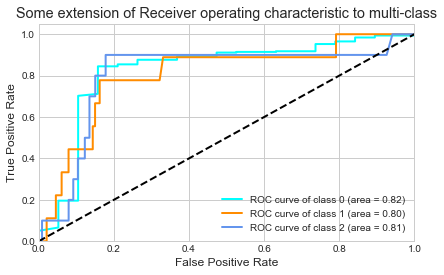

In [692]:
y_score = clf.predict_proba(X_test_ord)
lb =  LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_ord)

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(n_classes):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
#mean_tpr /= n_classes

#fpr["macro"] = all_fpr
#tpr["macro"] = mean_tpr
#roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/

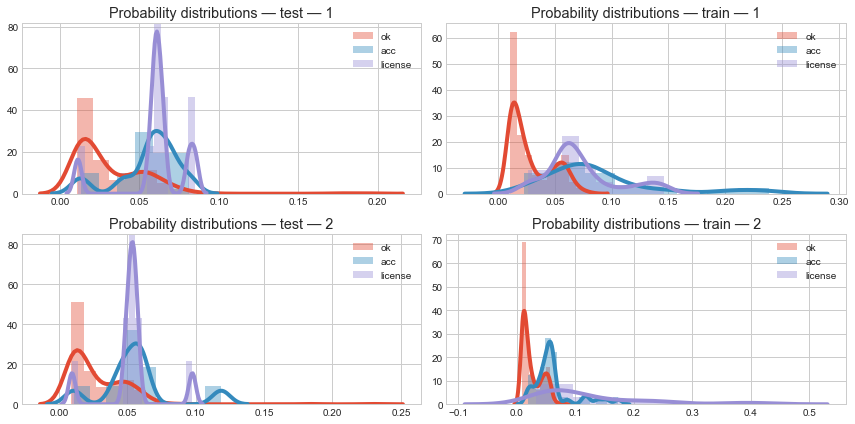

In [693]:
new_prob = np.append(prob, y_test_ord.values.reshape(335,1), axis=1)
new_prob_tr = np.append(prob_tr, y_train_ord.values.reshape(1005, 1), axis=1)

fig = plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
ax = sns.distplot(new_prob[new_prob[:, 3] == 0][:, 1], label='ok')
ax = sns.distplot(new_prob[new_prob[:, 3] == 1][:, 1], label = 'acc')
ax = sns.distplot(new_prob[new_prob[:, 3] == 2][:, 1], label = 'license')
ax.legend()
ax.set_title('Probability distributions — test — 1')

plt.subplot(2, 2, 2)
ax = sns.distplot(new_prob_tr[new_prob_tr[:, 3] == 0][:, 1], label='ok')
ax = sns.distplot(new_prob_tr[new_prob_tr[:, 3] == 1][:, 1], label = 'acc')
ax = sns.distplot(new_prob_tr[new_prob_tr[:, 3] == 2][:, 1], label = 'license')
ax.legend()
ax.set_title('Probability distributions — train — 1')

plt.subplot(2, 2, 3)
ax = sns.distplot(new_prob[new_prob[:, 3] == 0][:, 2], label='ok')
ax = sns.distplot(new_prob[new_prob[:, 3] == 1][:, 2], label = 'acc')
ax = sns.distplot(new_prob[new_prob[:, 3] == 2][:, 2], label = 'license')
ax.legend()
ax.set_title('Probability distributions — test — 2')

plt.subplot(2, 2, 4)
ax = sns.distplot(new_prob_tr[new_prob_tr[:, 3] == 0][:, 2], label='ok')
ax = sns.distplot(new_prob_tr[new_prob_tr[:, 3] == 1][:, 2], label = 'acc')
ax = sns.distplot(new_prob_tr[new_prob_tr[:, 3] == 2][:, 2], label = 'license')
ax.legend()
ax.set_title('Probability distributions — train — 2')


plt.tight_layout();

In [694]:
importances = list(zip(clf.feature_importances_, X_train.columns))
importances.sort(reverse=True)
importances

[(0.0636518158433281, 't2_3_E.6'),
 (0.05736535988570335, 't4_4_080000_2'),
 (0.04521685526955528, '4.2000000000000002'),
 (0.04470064398103599, 't4_4_030000_2'),
 (0.04235883035920101, 't4_4_030000_1'),
 (0.03894969157922585, 't2_E.6_diff'),
 (0.03132340544733963, 't4_1_4'),
 (0.028759364027706374, 't4_1_3'),
 (0.028610891575107707, 't5_59'),
 (0.024792852057967725, 't4_4_080000_1'),
 (0.02392143683319712, '5.2999999999999998'),
 (0.022866457908158222, '2.2999999999999998'),
 (0.022094070313402932, 't5_58'),
 (0.01931088620939035, 't5_47'),
 (0.018853262899848372, 't5_52'),
 (0.01847079184704533, 't4_4_030000_3'),
 (0.018334474474761005, '5.5'),
 (0.01677966768546878, '1.7'),
 (0.015547383951595306, 't4_1_2'),
 (0.013827080900013873, 't5_63'),
 (0.013688486049555151, 't4_4_45.00.00_2'),
 (0.013634786521360966, '5.2000000000000002'),
 (0.01357760735254758, 't4_4_050000_2'),
 (0.011892167803196177, 't2_1_E.6'),
 (0.011865043407834997, '1.1000000000000001'),
 (0.010963015291313214, 't2_E

* t2_3_E.6,"Трудоустройство, Изменение относительно прошлого года"
* t4_4_080000_2, Экономика и управление, Доля приведенного контингента студентов по   от общего приведенного контингента студентов организации
* 4.2000000000000002,"Доля доходов из средств от приносящей доход деятельности в доходах по всем видам финансового обеспечения (деятельности) образовательной организации, %"
* t4_4_030000_2, Гуманитарные науки, Доля приведенного контингента студентов по   от общего приведенного контингента студентов организации
* t2_E.6_diff Трудоустройство, отклонение от показателя
* t4_1_4 % обучающихся по договорам платных услуг
* t5_59,"Доля доходов филиала  из федерального бюджета, %"
* 5.2999999999999998,"Общая площадь учебно-лабораторных помещений в расчете на одного студента (приведенного контингента), закрепленных на праве оперативного управления, м"
* 2.2999999999999998,"Количество цитирований публикаций, изданных за последние 5 лет, индексируемых в Российском индексе научного цитирования (далее – РИНЦ) в расчете на 100 НПР, ед."
* t5_58,"Доля доходов филиала  из внебюджетных источников, %"
* t5_47,"Площадь учебно-лабораторных зданий, м"
* t5_52,"Количество персональных компьютеров, ед."

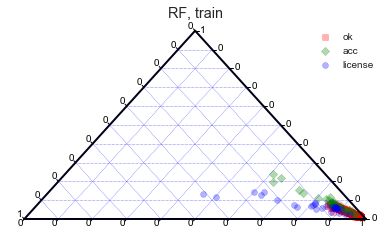

In [695]:
scale = 1
figure, tax = ternary.figure(scale=scale)
#figure.set_size_inches(8, 8)
# Plot a few different styles with a legend
tax.scatter(new_prob_tr[new_prob_tr[:, 3] == 0], marker='s', color='red', label="ok", alpha=0.3)
tax.scatter(new_prob_tr[new_prob_tr[:, 3] == 1], marker='D', color='green', label="acc", alpha=0.3)
tax.scatter(new_prob_tr[new_prob_tr[:, 3] == 2], color='blue', label="license", alpha=0.3)
tax.legend()

tax.set_title("RF, train")
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.1, color="blue")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.show()

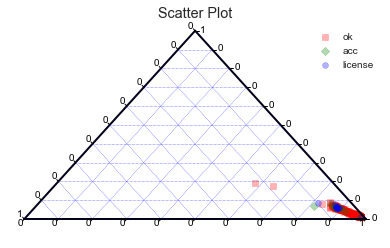

In [696]:
scale = 1
figure, tax = ternary.figure(scale=scale)
#figure.set_size_inches(8, 8)
# Plot a few different styles with a legend
tax.scatter(new_prob[new_prob[:, 3] == 0], marker='s', color='red', label="ok", alpha=0.3)
tax.scatter(new_prob[new_prob[:, 3] == 1], marker='D', color='green', label="acc", alpha=0.3)
tax.scatter(new_prob[new_prob[:, 3] == 2], color='blue', label="license", alpha=0.3)
tax.legend()

tax.set_title("Scatter Plot")
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=0.1, color="blue")
tax.ticks(axis='lbr', linewidth=1, multiple=0.1)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.show()


#### MLogit on RF output

In [697]:
mlogit = sm.MNLogit(y_train_ord, X_train_ord[['t2_3_E.6', 't4_4_080000_2', '4.2000000000000002', 
                                              't4_4_030000_2', 't2_E.6_diff', 't4_1_4', 't5_59',
                                              '5.2999999999999998', '2.2999999999999998', 't5_47', 't5_52']])
result = mlogit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.221803
         Iterations 11


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
===================================================================
Model:                MNLogit          Pseudo R-squared: 0.201     
Dependent Variable:   det_pr           AIC:              489.8246  
Date:                 2019-04-08 10:11 BIC:              597.9050  
No. Observations:     1005             Log-Likelihood:   -222.91   
Df Model:             20               LL-Null:          -279.06   
Df Residuals:         983              LLR p-value:      7.4473e-15
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       11.0000                                      
-------------------------------------------------------------------
    det_pr = 0      Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-------------------------------------------------------------------
          t2_3_E.6 -0.0074   0.0232 -0.3203 0.7488  -0.0530  0.0381
     t4_4_080000_2  6.4265   9.7249  0.6608 0.5087 -12.6339 25.4869
4.2000000000000002 -0.0052   0.0158 -0.3316 0.7402  -0.0363  0.0258
     t4_4_030000_2  1.5292   9.9450  0.1538 0.8778 -17.9626 21.0211
       t2_E.6_diff -1.7670   0.7483 -2.3614 0.0182  -3.2336 -0.3004
            t4_1_4 -0.0196   0.0161 -1.2207 0.2222  -0.0511  0.0119
             t5_59 -0.0606   0.0142 -4.2708 0.0000  -0.0884 -0.0328
5.2999999999999998  0.0010   0.0007  1.3726 0.1699  -0.0004  0.0024
2.2999999999999998  0.0000   0.0000  0.8955 0.3705  -0.0000  0.0001
             t5_47  0.0000   0.0000  0.3079 0.7582  -0.0000  0.0001
             t5_52 -0.0023   0.0014 -1.6756 0.0938  -0.0051  0.0004
-------------------------------------------------------------------
    det_pr = 1      Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-------------------------------------------------------------------
          t2_3_E.6 -0.0105   0.0216 -0.4872 0.6261  -0.0530  0.0319
     t4_4_080000_2  6.5487   9.7285  0.6731 0.5009 -12.5188 25.6161
4.2000000000000002 -0.0012   0.0176 -0.0665 0.9470  -0.0356  0.0333
     t4_4_030000_2  2.1539   9.9466  0.2166 0.8286 -17.3410 21.6488
       t2_E.6_diff -2.5022   0.7243 -3.4544 0.0006  -3.9218 -1.0825
            t4_1_4 -0.0248   0.0178 -1.3953 0.1629  -0.0597  0.0100
             t5_59 -0.0387   0.0120 -3.2397 0.0012  -0.0622 -0.0153
5.2999999999999998 -0.0012   0.0067 -0.1775 0.8591  -0.0144  0.0120
2.2999999999999998 -0.0000   0.0001 -0.4124 0.6801  -0.0002  0.0001
             t5_47 -0.0001   0.0000 -2.5584 0.0105  -0.0002 -0.0000
             t5_52  0.0001   0.0001  1.2520 0.2106  -0.0001  0.0002
===================================================================

"""

In [698]:
pred_mlogit = result.predict(X_test_ord[['t2_3_E.6', 't4_4_080000_2', '4.2000000000000002', 't4_4_030000_2', 
                              't2_E.6_diff', 't4_1_4', 't5_59', '5.2999999999999998', '2.2999999999999998', 
                              't5_47', 't5_52']])

In [699]:
#new_pred_mlogit = pd.concat([pred_mlogit, y_test_ord], axis=1)

#ax = sns.distplot(new_pred_mlogit[new_pred_mlogit['det_pr'] == 0][0], label='ok')
#ax = sns.distplot(new_pred_mlogit[new_pred_mlogit['det_pr'] == 1][0], label = 'acc')
#ax = sns.distplot(new_pred_mlogit[new_pred_mlogit['det_pr'] == 2][0], label = 'license')
#ax.legend()
#ax.set_title('True labels prob dist');

In [700]:
#new_pred_mlogit

In [701]:
df.loc[689]['name'] # 1 показатель
df.loc[491]['name'] # 5 показателей
df.loc[766]['name'] # 3 показателя 
df.loc[468]['name'] # кривые данные
df.loc[657]['name'] # консерватория
df.loc[576]['name'] # 1 показатель, странные данные


'Сочинский институт моды, бизнеса и права'

In [703]:
lb =  LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_ord)

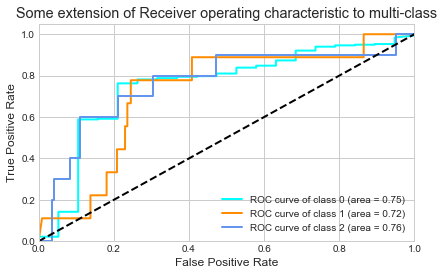

In [704]:
y_score = pred_mlogit

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:,i], y_score[i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(n_classes):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
#mean_tpr /= n_classes

#fpr["macro"] = all_fpr
#tpr["macro"] = mean_tpr
#roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#### Logit на подобранных фичах

In [705]:
mlogit_2 = sm.MNLogit(y_train_ord, X_train_ord[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2']])
result_2 = mlogit_2.fit()
result_2.summary2()

Optimization terminated successfully.
         Current function value: 0.224415
         Iterations 11


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: MNLogit
==================================================================
Model:               MNLogit          Pseudo R-squared: 0.192     
Dependent Variable:  det_pr           AIC:              483.0735  
Date:                2019-04-08 10:12 BIC:              561.6774  
No. Observations:    1005             Log-Likelihood:   -225.54   
Df Model:            14               LL-Null:          -279.06   
Df Residuals:        989              LLR p-value:      2.0783e-16
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      11.0000                                      
------------------------------------------------------------------
    det_pr = 0      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
             t5_59 -0.0367   0.0133 -2.7615 0.0058 -0.0627 -0.0106
       t2_E.6_diff -1.4009   0.7648 -1.8318 0.0670 -2.8998  0.0980
               1.2 -0.0234   0.0109 -2.1400 0.0324 -0.0448 -0.0020
          t2_1_E.7 -0.0036   0.0019 -1.8532 0.0639 -0.0074  0.0002
4.0999999999999996 -0.0001   0.0001 -0.9753 0.3294 -0.0004  0.0001
7.2999999999999998 -0.0029   0.0085 -0.3374 0.7358 -0.0196  0.0138
            t4_1_4 -0.0157   0.0073 -2.1450 0.0320 -0.0301 -0.0014
            t4_1_2 -0.0004   0.0004 -0.9673 0.3334 -0.0011  0.0004
------------------------------------------------------------------
    det_pr = 1      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
             t5_59 -0.0306   0.0115 -2.6623 0.0078 -0.0531 -0.0081
       t2_E.6_diff -2.8314   0.6565 -4.3129 0.0000 -4.1181 -1.5447
               1.2 -0.0196   0.0107 -1.8236 0.0682 -0.0406  0.0015
          t2_1_E.7 -0.0051   0.0026 -1.9857 0.0471 -0.0101 -0.0001
4.0999999999999996 -0.0002   0.0002 -1.1671 0.2432 -0.0006  0.0001
7.2999999999999998  0.0072   0.0098  0.7382 0.4604 -0.0119  0.0263
            t4_1_4 -0.0244   0.0087 -2.8198 0.0048 -0.0414 -0.0074
            t4_1_2 -0.0013   0.0008 -1.6281 0.1035 -0.0028  0.0003
==================================================================

"""

In [706]:
pred_mlogit_2 = result_2.predict(X_test_ord[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2']])

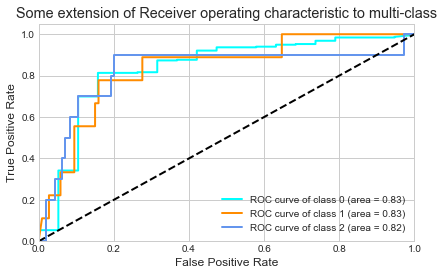

In [707]:
y_score = pred_mlogit_2
y_test_bin = lb.fit_transform(y_test_ord)

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:,i], y_score[i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(n_classes):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
#mean_tpr /= n_classes

#fpr["macro"] = all_fpr
#tpr["macro"] = mean_tpr
#roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#### Логит на подобранных + ok_susp

In [714]:
# убираем текстовые переменные
X_ord = df.drop(['address', 'comment', 'comment_date', 'name', 'response', 'status',
       't1_3', 't1_4', 't1_5', 't1_6', 't1_7', 'all_pr', 'det_pr'], axis=1)
# убираем бенчмарки
drop_col = [col for col in df if col.startswith('t2_2_')]
X_ord = X_ord.drop(drop_col, axis = 1)
X_train_ord_new, X_test_ord_new, y_train_ord_new, y_test_ord_new = train_test_split(X_new, df['det_pr'],
                                                                    test_size=0.25, random_state=35, shuffle=True)

In [716]:
mlogit_3 = sm.MNLogit(y_train_ord_new, X_train_ord_new[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2', 'ok_susp']])
result_3 = mlogit_3.fit()
result_3.summary2()

         Current function value: 0.109461
         Iterations: 35


/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: MNLogit
=========================================================================
Model:                  MNLogit            Pseudo R-squared:   0.606     
Dependent Variable:     det_pr             AIC:                256.0172  
Date:                   2019-04-08 10:17   BIC:                344.4466  
No. Observations:       1005               Log-Likelihood:     -110.01   
Df Model:               16                 LL-Null:            -279.06   
Df Residuals:           987                LLR p-value:        3.1033e-62
Converged:              0.0000             Scale:              1.0000    
No. Iterations:         35.0000                                          
-------------------------------------------------------------------------
    det_pr = 0      Coef.    Std.Err.    t    P>|t|    [0.025     0.975] 
-------------------------------------------------------------------------
             t5_59  -0.0625    0.0169 -3.6968 0.0002    -0.0956   -0.0293
       t2_E.6_diff  -1.4537    1.1697 -1.2429 0.2139    -3.7462    0.8388
               1.2  -0.0317    0.0106 -2.9930 0.0028    -0.0525   -0.0109
          t2_1_E.7  -0.0076    0.0024 -3.1514 0.0016    -0.0123   -0.0029
4.0999999999999996  -0.0002    0.0002 -1.0784 0.2808    -0.0007    0.0002
7.2999999999999998  -0.0062    0.0137 -0.4549 0.6492    -0.0330    0.0206
            t4_1_4   0.0242    0.0129  1.8798 0.0601    -0.0010    0.0495
            t4_1_2  -0.0010    0.0006 -1.7671 0.0772    -0.0021    0.0001
           ok_susp -23.6409 5039.8796 -0.0047 0.9963 -9901.6235 9854.3417
-------------------------------------------------------------------------
    det_pr = 1      Coef.    Std.Err.    t    P>|t|    [0.025     0.975] 
-------------------------------------------------------------------------
             t5_59  -0.0520    0.0143 -3.6286 0.0003    -0.0801   -0.0239
       t2_E.6_diff  -2.5484    1.1485 -2.2189 0.0265    -4.7995   -0.2974
               1.2  -0.0288    0.0111 -2.5934 0.0095    -0.0506   -0.0070
          t2_1_E.7  -0.0090    0.0028 -3.1691 0.0015    -0.0146   -0.0034
4.0999999999999996  -0.0003    0.0002 -1.1010 0.2709    -0.0008    0.0002
7.2999999999999998   0.0074    0.0140  0.5271 0.5981    -0.0201    0.0349
            t4_1_4   0.0120    0.0131  0.9177 0.3588    -0.0137    0.0377
            t4_1_2  -0.0021    0.0010 -2.1797 0.0293    -0.0040   -0.0002
           ok_susp -23.0444 4211.9055 -0.0055 0.9956 -8278.2276 8232.1388
=========================================================================

"""

In [717]:
pred_mlogit_3 = result_3.predict(X_test_ord_new[[ 't5_59', 't2_E.6_diff', '1.2', 't2_1_E.7', '4.0999999999999996', 
                                           '7.2999999999999998', 't4_1_4', 't4_1_2', 'ok_susp']])

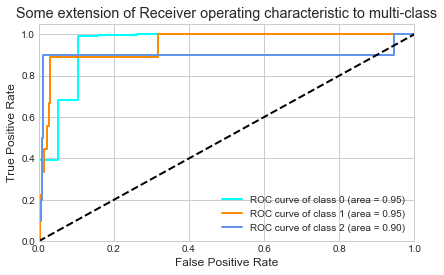

In [718]:
y_score = pred_mlogit_3
y_test_bin = lb.fit_transform(y_test_ord_new)

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:,i], y_score[i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(n_classes):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
#mean_tpr /= n_classes

#fpr["macro"] = all_fpr
#tpr["macro"] = mean_tpr
#roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#### XGBoost

In [708]:
gb = GradientBoostingClassifier()
gb.fit(X_train_ord, y_train_ord)
pred = gb.predict_proba(X_test_ord)
pred_tr = gb.predict_proba(X_train_ord)

/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ola/anaconda/lib/python3.5/site-packages/

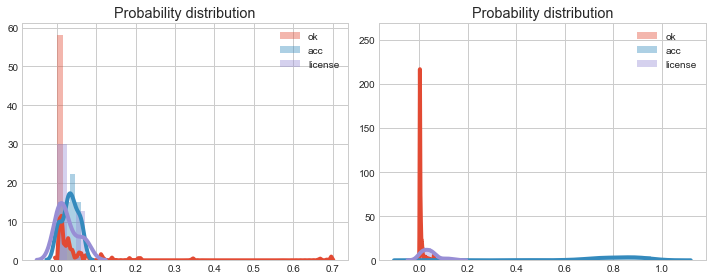

In [395]:
new_gb_prob = np.append(pred, y_test_ord.values.reshape(335,1), axis=1)
new_gb_prob_tr = np.append(pred_tr, y_train_ord.values.reshape(1005,1), axis=1)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ax = sns.distplot(new_gb_prob[new_gb_prob[:, 3] == 0][:, 1], label='ok')
ax = sns.distplot(new_gb_prob[new_gb_prob[:, 3] == 1][:, 1], label = 'acc')
ax = sns.distplot(new_gb_prob[new_gb_prob[:, 3] == 2][:, 1], label = 'license')
ax.legend()
ax.set_title('Probability distribution')

plt.subplot(1, 2, 2)
ax = sns.distplot(new_gb_prob_tr[new_gb_prob_tr[:, 3] == 0][:, 1], label='ok')
ax = sns.distplot(new_gb_prob_tr[new_gb_prob_tr[:, 3] == 1][:, 1], label = 'acc')
ax = sns.distplot(new_gb_prob_tr[new_gb_prob_tr[:, 3] == 2][:, 1], label = 'license')
ax.legend()
ax.set_title('Probability distribution')
plt.tight_layout()

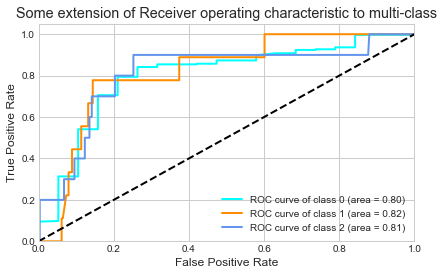

In [711]:
y_score = pred
y_test_bin = lb.fit_transform(y_test_ord)

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:,i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(n_classes):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
#mean_tpr /= n_classes

#fpr["macro"] = all_fpr
#tpr["macro"] = mean_tpr
#roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()